# **Shoppedia Delivery Prediction**


**E-Commerce Shipping Data**<br>
**Deskripsi**<br>
* This notebook is an analysis of shipping data from Shoppedia e-commerce company to determine if packages arrived on time or not<br>

**Kelompok 1 - ShipTime Forecasters**
- Aisyah Nur Hasanah
- Alvin Kurniawan Hanafie
- Awalsyah Erlangga
- Berliana Ayu Aprilia
- Gladys Olivia
- Kevin Munandar


# Import Library

In [1]:
pip install optbinning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.6/211.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 23.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.24.4 which is incompatible.


In [2]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.8 MB/s eta 0:00:00


In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 4.6 MB/s eta 0:00:00


In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from imblearn import under_sampling, over_sampling
from sklearn.preprocessing import OrdinalEncoder
from numpy import asarray
from sklearn.model_selection import train_test_split
from optbinning import BinningProcess
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from scipy.stats import ks_2samp
import shap
from sklearn.metrics import roc_curve
from sklearn import metrics


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

(CVXPY) Oct 27 02:03:10 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 27 02:03:10 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
numpy version :  1.23.5
pandas version :  1.5.3
seaborn version :  0.12.2


In [5]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# **Exploratory Data Analysis**

## Load and Describe Data

### Load Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
file_id = '1BSZHP0pTdFt_DlNH_jcELYoxvNtQ0mx1'
link = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(link)
df.head()


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


## Descriptive Statistic

### Info Dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


- Dataset berisikan 12 kolom, dengan jumlah 10999 baris.
- Tipe data, dengan nama dan nilai dalam kolomnya sudah sesuai, kecuali ID yang akan diubah menjadi tipe data string.
- Dataset lengkap, tidak ada nilai kosong.
- Variable Reached.on.Time_Y.N akan diubah namanya menjadi Delivered_on_Time untuk agar lebih intuitif dan sesuai dengan business metric yang akan digunakan.  


In [9]:
#ubah data type id ke string
df['ID']=df['ID'].astype(str)
df.rename(columns = {'Reached.on.Time_Y.N': 'Delivered_on_Time'}, inplace = True)
print(df.dtypes)

ID                     object
Warehouse_block        object
Mode_of_Shipment       object
Customer_care_calls     int64
Customer_rating         int64
Cost_of_the_Product     int64
Prior_purchases         int64
Product_importance     object
Gender                 object
Discount_offered        int64
Weight_in_gms           int64
Delivered_on_Time       int64
dtype: object


In [10]:
df.isna().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Delivered_on_Time      0
dtype: int64

In [11]:
df.duplicated().any()

False

Tidak ada data kosong dan data duplikat.

### Deskripsi Statistik pada Dataset

In [12]:
numerical = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Delivered_on_Time']
categorical = ['ID', 'Warehouse_block', 'Mode_of_Shipment','Product_importance','Gender']

In [13]:
df[numerical].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Delivered_on_Time
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


- Semua nilai variable numeric (min/max) masuk akal.
- Terdapat perbedaan yang cukup jauh antara nilai mean dan median pada feature Prior_purchases, Discount_offered, dimana nilai mean lebih besar dari nilai mediannya. Perbedaan nilai mean dan median variable Discount_offered cukup jauh (13.37 dan 7.00).
- Nilai mean dari Weight_in_gms lebih kecil dari nilai mediannya.
- Terdapat hal unik dimana setiap transaksi memiliki minimal 2 customer care calls.
- Untuk nilai target (Delivered_on_Time), nilai 0 menunjukkan pengiriman barang tepat waktu, dan nilai 1 menunjukkan pengiriman barang yang tidak tepat waktu.

#### Jumlah nilai unik per variable numerik

In [14]:
for col in numerical:
    print(f'Total nilai unik pada {col} :')
    print(df[col].value_counts())
    print()
    print(f'Total persentase nilai unik pada {col} :')
    print(round(df[col].value_counts(normalize = True)*100,2))
    print()

Total nilai unik pada Customer_care_calls :
4    3557
3    3217
5    2328
6    1013
2     638
7     246
Name: Customer_care_calls, dtype: int64

Total persentase nilai unik pada Customer_care_calls :
4    32.34
3    29.25
5    21.17
6     9.21
2     5.80
7     2.24
Name: Customer_care_calls, dtype: float64

Total nilai unik pada Customer_rating :
3    2239
1    2235
4    2189
5    2171
2    2165
Name: Customer_rating, dtype: int64

Total persentase nilai unik pada Customer_rating :
3    20.36
1    20.32
4    19.90
5    19.74
2    19.68
Name: Customer_rating, dtype: float64

Total nilai unik pada Cost_of_the_Product :
245    110
257    109
260    106
254    101
264    100
      ... 
107      5
99       5
120      5
96       5
122      4
Name: Cost_of_the_Product, Length: 215, dtype: int64

Total persentase nilai unik pada Cost_of_the_Product :
245    1.00
257    0.99
260    0.96
254    0.92
264    0.91
       ... 
107    0.05
99     0.05
120    0.05
96     0.05
122    0.04
Name: Cost_of

- Customer care calls paling banyak pada angka 4 (32.34%) dan angka 3 (29.25%).
- Nilai rating 1 - 5 cenderung mendapat angka yang sama sekitar 20%.
- Prior_purchase terbanyak pada angka 3 dengan persentase 35.96% dan angka 2 dengan persentase (23.63%).
- Kebanyakan diskon yang diberikan di bawah 10%.
- Perbandingan target Delivered_on_Time cukup seimbang, dengan perbandingan persentase 59.67% dan 40.33%, sehingga tidak terjadi permasalahan class imbalance.

In [15]:
df[categorical].describe()

,ID,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
count,10999,10999,10999,10999,10999
unique,10999,5,3,3,2
top,1,F,Ship,low,F
freq,1,3666,7462,5297,5545


- Semua nilai ID bersifat unique, sehingga tidak ada duplikat dalam ID. Kolom ID tidak diikutkan dalam Exploratory Data Analysis karena tidak memengaruhi dataset.

#### Jumlah nilai unik per variable kategorikal

In [16]:
categorical = ['Warehouse_block', 'Mode_of_Shipment','Product_importance','Gender']

In [17]:
for col in categorical:
    print(f'Total nilai unik pada {col} :')
    print(df[col].value_counts())
    print()
    print(f'Total persentase nilai unik pada {col} :')
    print(round(df[col].value_counts(normalize = True)*100,2))
    print()


Total nilai unik pada Warehouse_block :
F    3666
D    1834
A    1833
B    1833
C    1833
Name: Warehouse_block, dtype: int64

Total persentase nilai unik pada Warehouse_block :
F    33.33
D    16.67
A    16.67
B    16.67
C    16.67
Name: Warehouse_block, dtype: float64

Total nilai unik pada Mode_of_Shipment :
Ship      7462
Flight    1777
Road      1760
Name: Mode_of_Shipment, dtype: int64

Total persentase nilai unik pada Mode_of_Shipment :
Ship      67.84
Flight    16.16
Road      16.00
Name: Mode_of_Shipment, dtype: float64

Total nilai unik pada Product_importance :
low       5297
medium    4754
high       948
Name: Product_importance, dtype: int64

Total persentase nilai unik pada Product_importance :
low       48.16
medium    43.22
high       8.62
Name: Product_importance, dtype: float64

Total nilai unik pada Gender :
F    5545
M    5454
Name: Gender, dtype: int64

Total persentase nilai unik pada Gender :
F    50.41
M    49.59
Name: Gender, dtype: float64



- Block F pada Variable Warehouse_block paling banyak dengan persentase 33.33%.
- Ship menjadi metode paling banyak (mendominasi) dalam variable Mode_of_Shipment dengan persentase 67.84%.
- Produk dengan tingkat importance low paling banyak pada variable Product_importance dengan persentase 48.16%. Produk dengan importance high  paling sedikit dengan persentase 8.62%.
- Persebaran gender Female dan Male cenderung merata dengan perbandingan persentase 50.41% dan 49.59%.
- Tidak ada nilai feature yang jumlahnya terlalu timpang, sehingga feature categorical masih dapat digunakan untuk Exploratory Data Analysis.

## Univariate Analysis

### Sebaran Feature Numerik

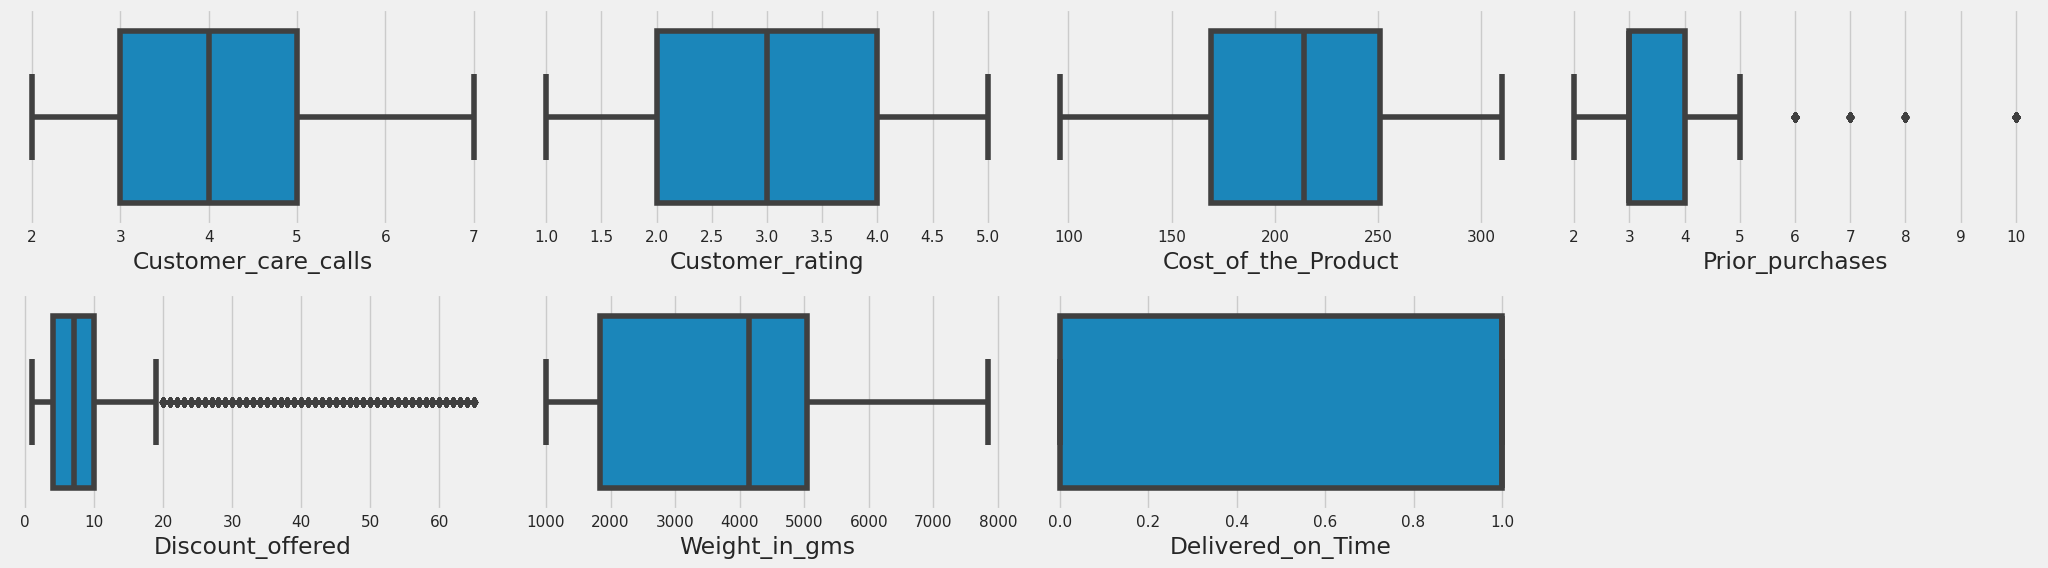

In [18]:
#Boxplot Features untuk mengecek outlier
for i in range(0, len(numerical)):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x=df[numerical[i]])
    plt.tight_layout()

- Variable Prior_purchases dan Discount_offered memiliki nilai outlier, terutama pada variable Discount_offered yang memiliki cukup banyak nilai outlier.

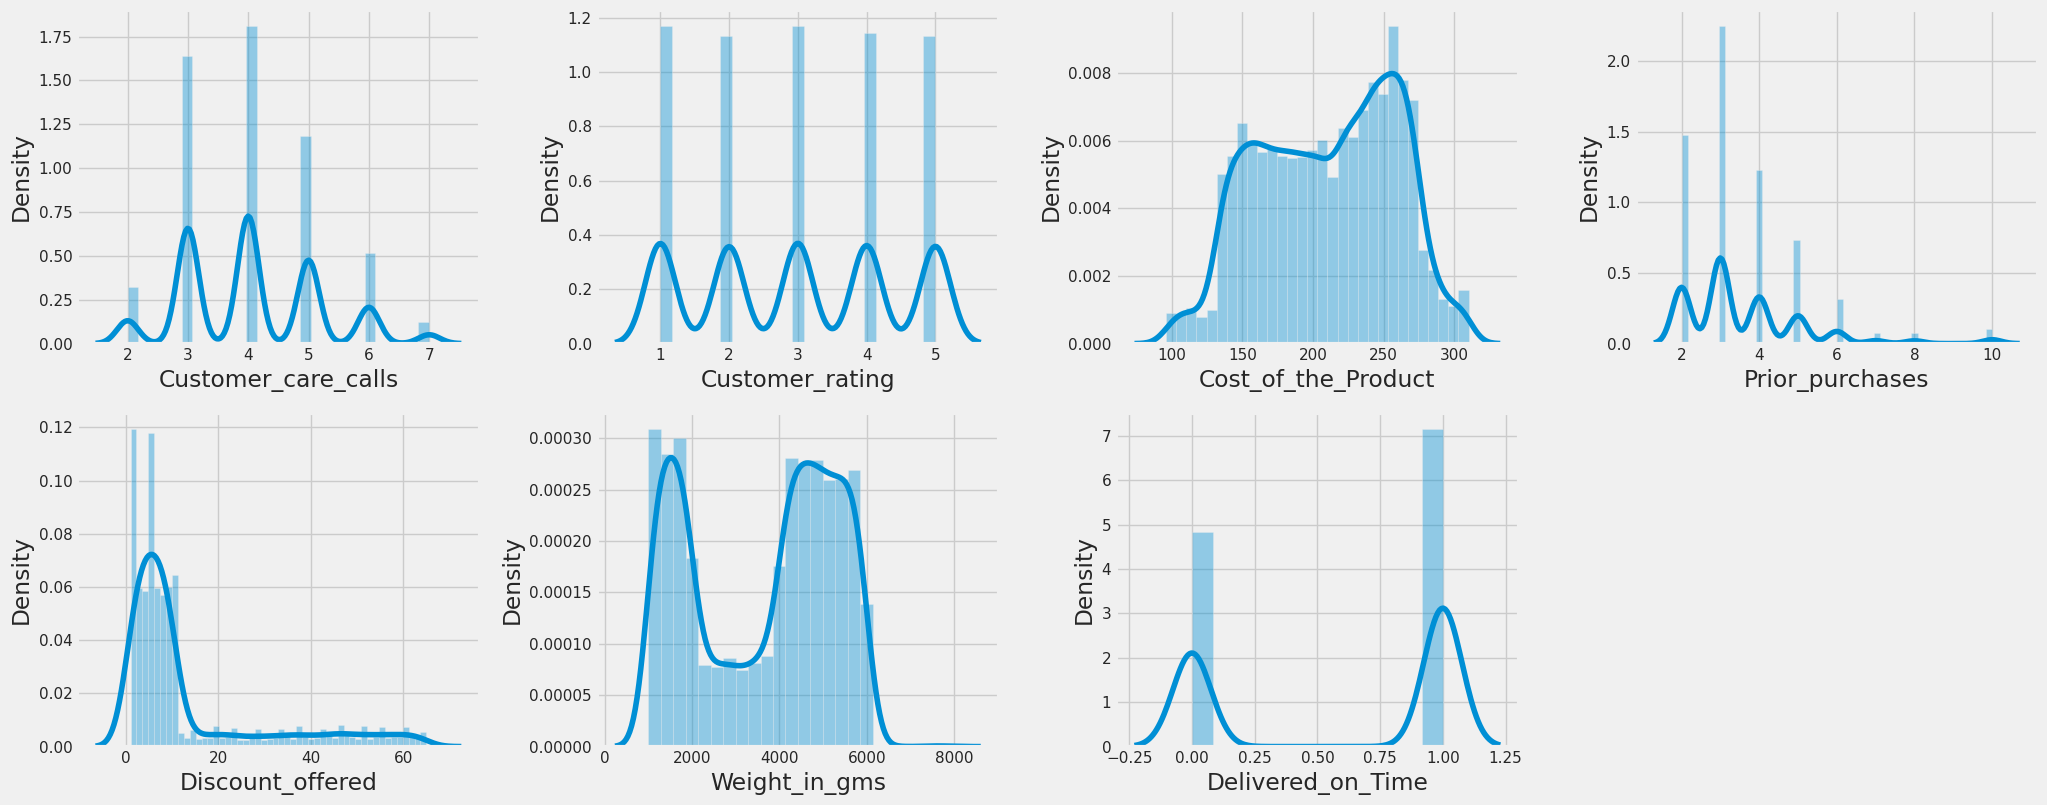

In [19]:
for i in range(0, len(numerical)):
    plt.subplot(2, 4, i+1)
    sns.distplot(df[numerical[i]], kde = True)
    plt.tight_layout()

- Customer_care_calls dan Prior_purchases memiliki sebaran yang mirip (cenderung right-skewed).
- Customer_rating memiliki sebaran unik, dimana tiap nilai rating memiliki nilai yang hampir sama.
- Cost_of_the_Product hampir mendekati sebaran distribusi normal (cenderung left-skewed).
- Discount_offered memiliki sebaran right-skewed.
- Weight_in_gms memiliki sebaran bimodal, dengan distribusi data terpusat pada 2 bagian.
- Delivered_on_Time dengan nilai 1 (pengiriman barang tidak tepat waktu) lebih mendominasi jumlahnya dibandingkan dengan nilai 0 (pengiriman barang tepat waktu).

#### Sebaran Fitur Numerical terhadap Target

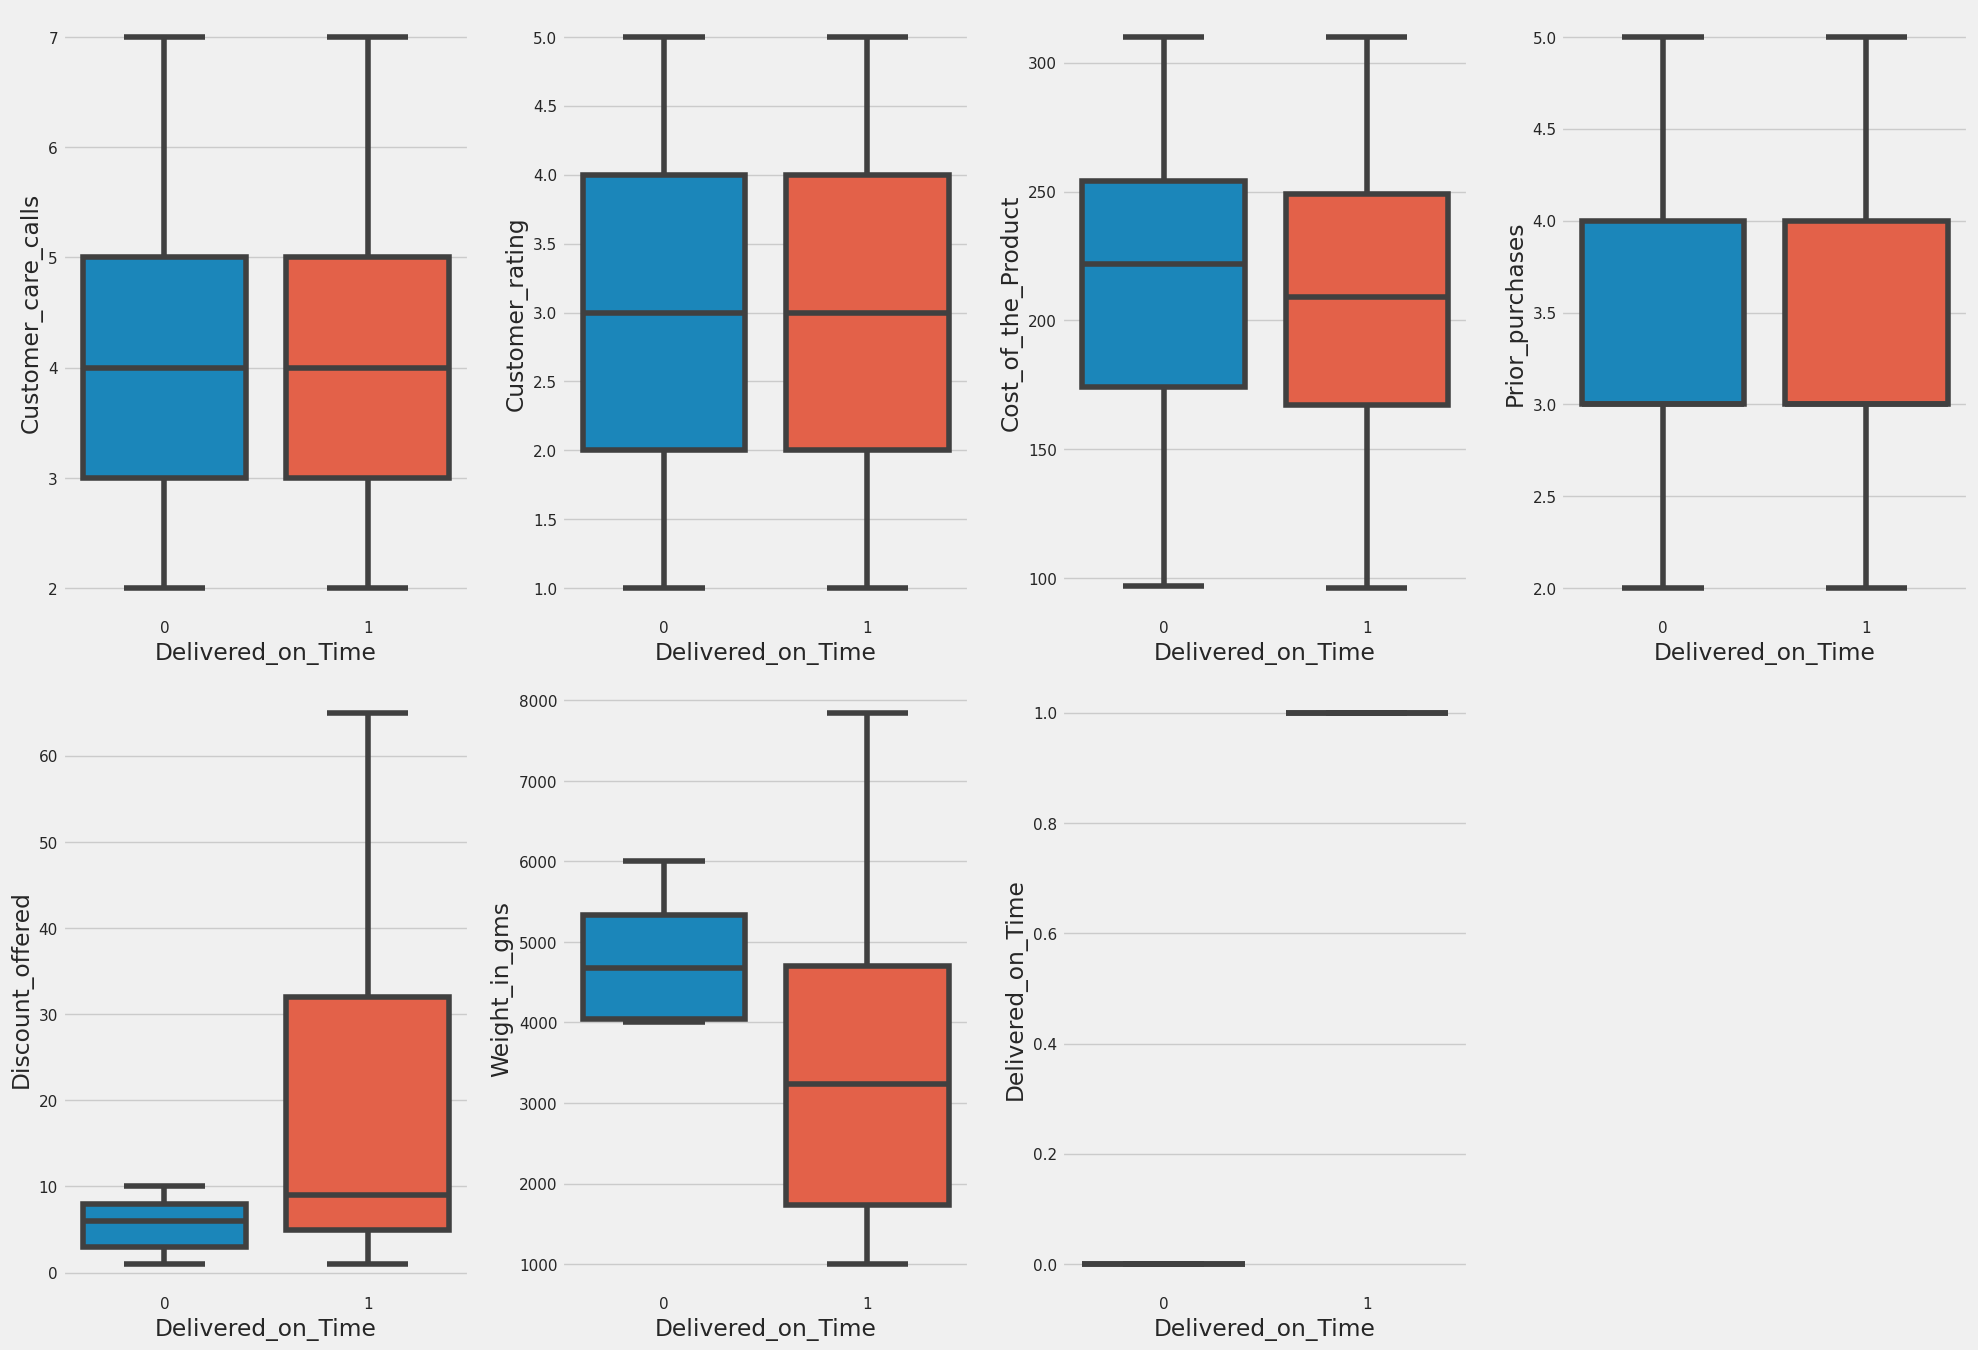

In [20]:
#Boxplot Features pada Delivered_on_Time
plt.figure(figsize = (20,20))
for i in range(0, len(numerical)):
    plt.subplot(3, 4, i+1)
    sns.boxplot(y=df[numerical[i]], x= 'Delivered_on_Time', data = df, showfliers = False)
    plt.tight_layout()

- Feature Cost_of_the_Product, Discount_offered, dan Weight_in_gms memiliki sebaran cukup berbeda terhadap target Delivered_on_Time, sehingga akan dianalisis lebih lanjut pada ketiga feature terkait.
- Feature Customer_care_calls, Customer_rating, dan Prior_purchases sebarannya hampir sama terhadap target Delivered_on_Time, sehingga EDA tidak berfokus pada ketiga feature ini.

#### Sebaran Fitur Numerical terhadap Target (secara proporsional)

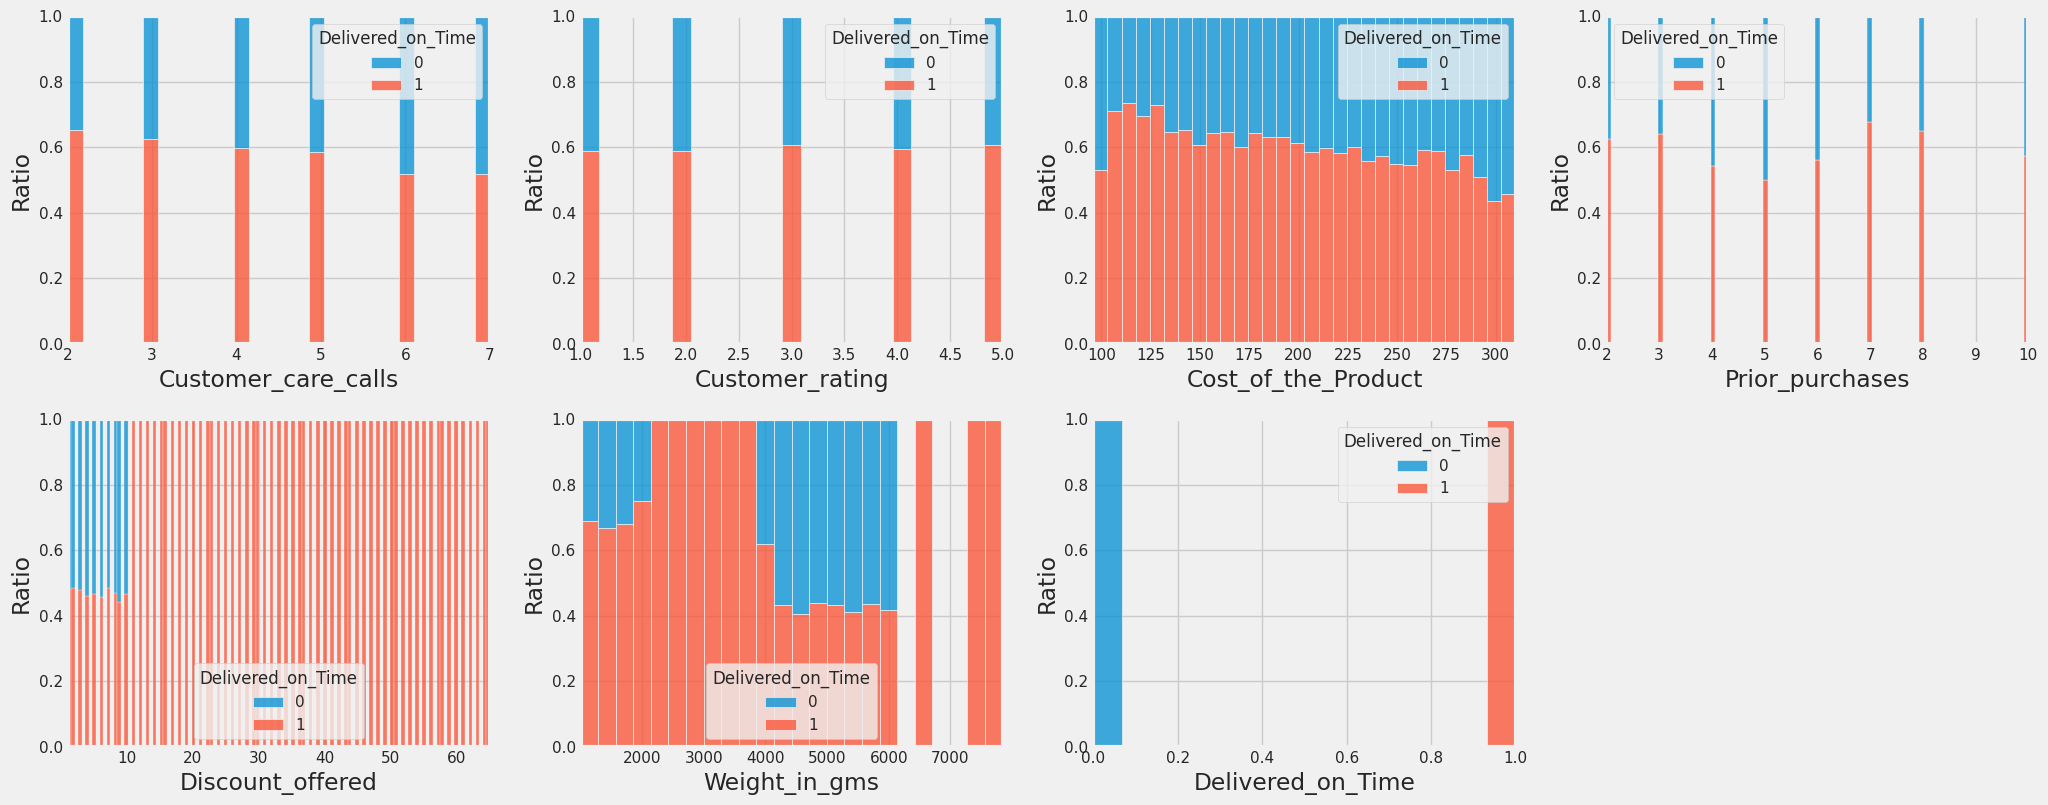

In [21]:
for i in range(0, len(numerical)):
    plt.subplot(2, 4, i+1)
    sns.histplot(x=df[numerical[i]], hue= 'Delivered_on_Time', data = df, multiple = 'fill')
    plt.ylabel('Ratio')
    plt.tight_layout()

- Semua pengiriman barang dengan diskon >10% tidak tepat waktu.
- Pengiriman barang dengan berat di antara 2000 - 4000 g dan di atas 6000 g tidak tepat waktu.
- Harga barang (Cost_of_the_Product) yang semakin tinggi cenderung membuat pengiriman barang tepat waktu.

### Sebaran Feature Categorical

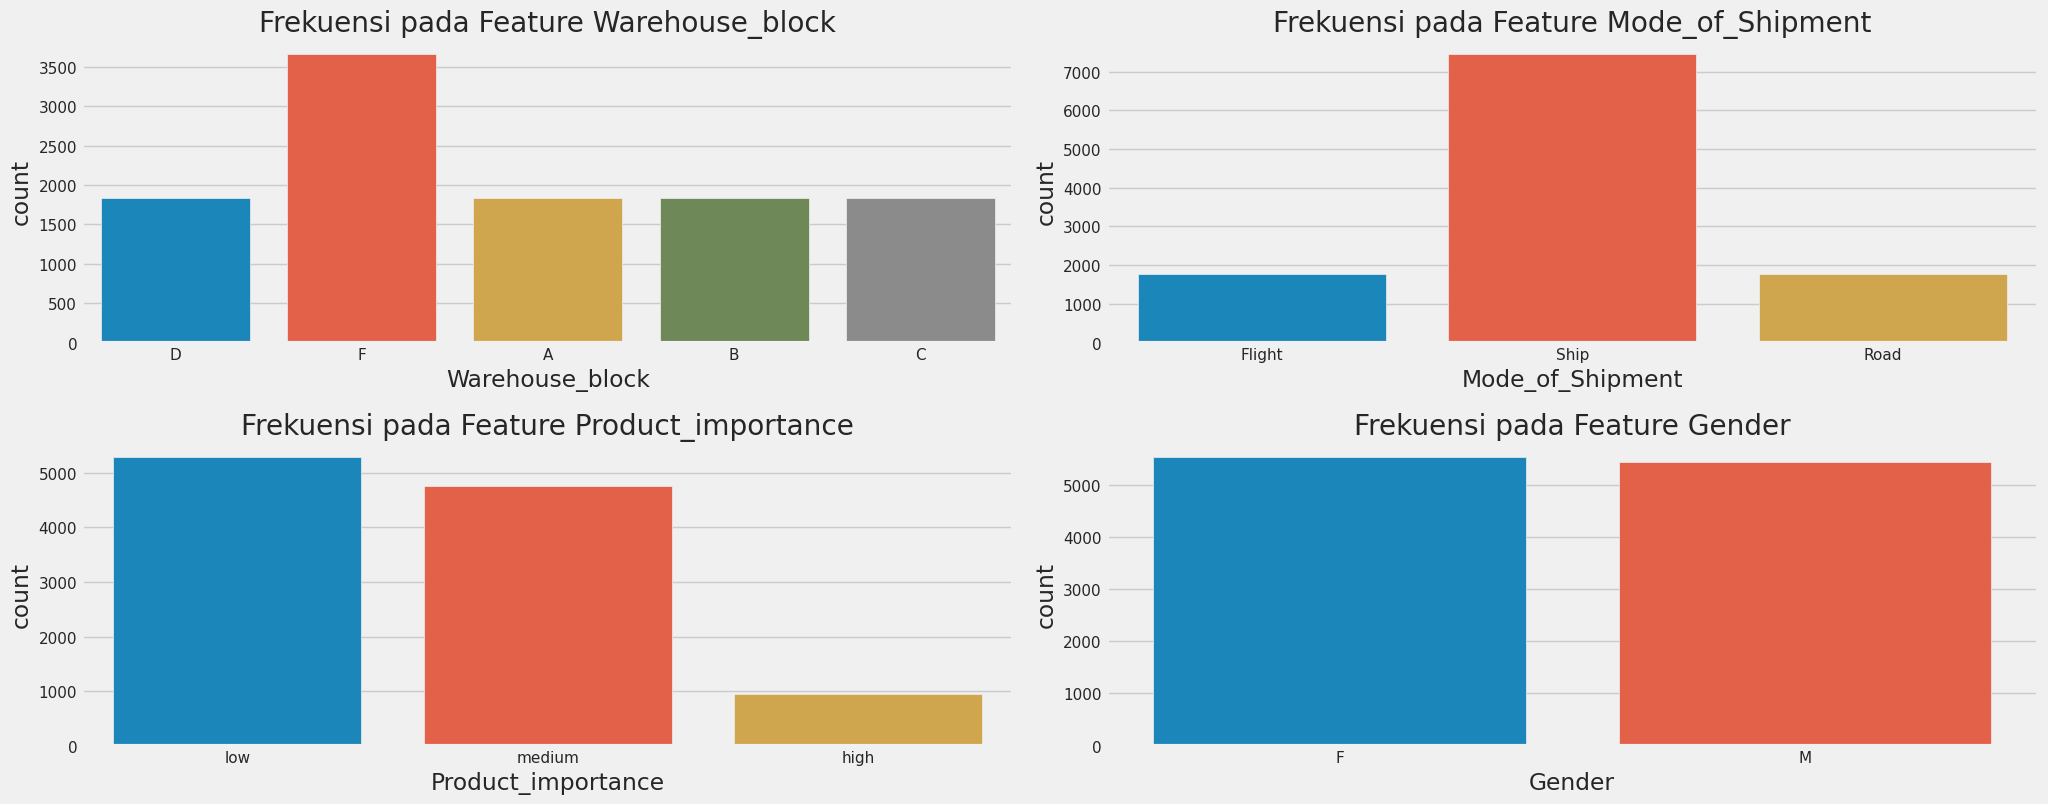

In [22]:
for i in range(0, len(categorical)):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=df[categorical[i]])
    plt.title(f'Frekuensi pada Feature {categorical[i]}')
    plt.tight_layout()


- Terdapat nilai feature yang mendominasi pada feature Warehouse_block (F), Mode_of_Shipment (Ship).
- Terdapat nilai feature yang menjadi minoritas dalam feature Product_importance (high).
- Nilai feature Gender merata dengan proporsi sekitar 50:50.
- Perbandingan nilai dalam feature tidak terlalu timpang, sehingga keempat fitur masih akan digunakan dalam Exploratory Data Analysis.

### Sebaran Feature Categorical dengan Target (secara proporsional)

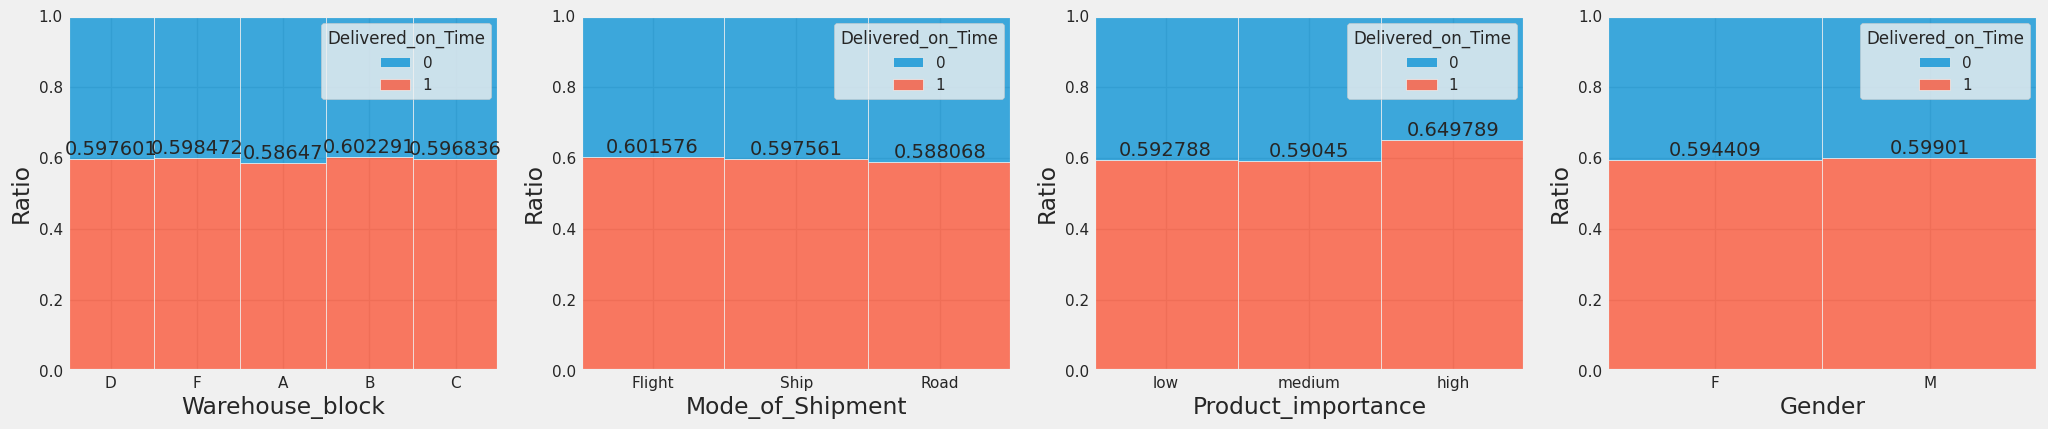

In [23]:
for i in range(0, len(categorical)):
    fig = plt.subplot(2, 4, i+1)
    sns.histplot(x=df[categorical[i]], hue= 'Delivered_on_Time', data = df, multiple = 'fill')
    plt.bar_label(fig.containers[0])
    plt.ylabel('Ratio')
    plt.tight_layout()

*   Barang yang terkirim tepat waktu terbanyak terdapat di warehouse block A. Sedangkan pada block B, paling banyak barang yang tidak terkirim tepat waktu.
*   Road menjadi metode pengiriman yang paling banyak yang berhasil mengirimkan barang tepat waktu, sedangkan Flight merupakan metode paling banyak yang tidak berhasil mengirim barang tepat waktu.
*   Product_importance yang tergolong low memiliki jumlah barang paling banyak yang berhasil terkirim tepat waktu, sedangkan produk yang tergolong high, paling banyak gagal dalam mengirimkan barang tepat waktu.
*   Rasio barang yang terkirim tepat waktu dengan yang tidak tepat waktu pada feature Gender cenderung sama.



### Follow up untuk Data Pre-Processing

- Akan dilakukan transformasi data untuk variable bersifat right skewed (Prior_purchases dan Discount_offered). Transformasi data akan dipilih pada metode yang robust terhadap outlier, untuk meminimalisir penghilangan data yang dikategorikan sebagai outlier.
- Akan dilakukan standardisasi data pada feature untuk menjaga agar data seimbang pada saat dilakukan pemodelan.
- Customer_care_calls dan Customer_rating tidak dilakukan transformasi karena sudah mendekati sebaran distribusi normal.
- Akan dilakukan feature encoding pada feature categorical, untuk mengubah nilai feature menjadi numerical.
- Semua feature akan dilakukan scaling sehingga skala antar feature sama.
- Tidak perlu dilakukan handling class imbalance, karena jumlah nilai pada target tidak mengalami ketimpangan (60:40).

## Multivariate Analysis

### Correlation Heatmap

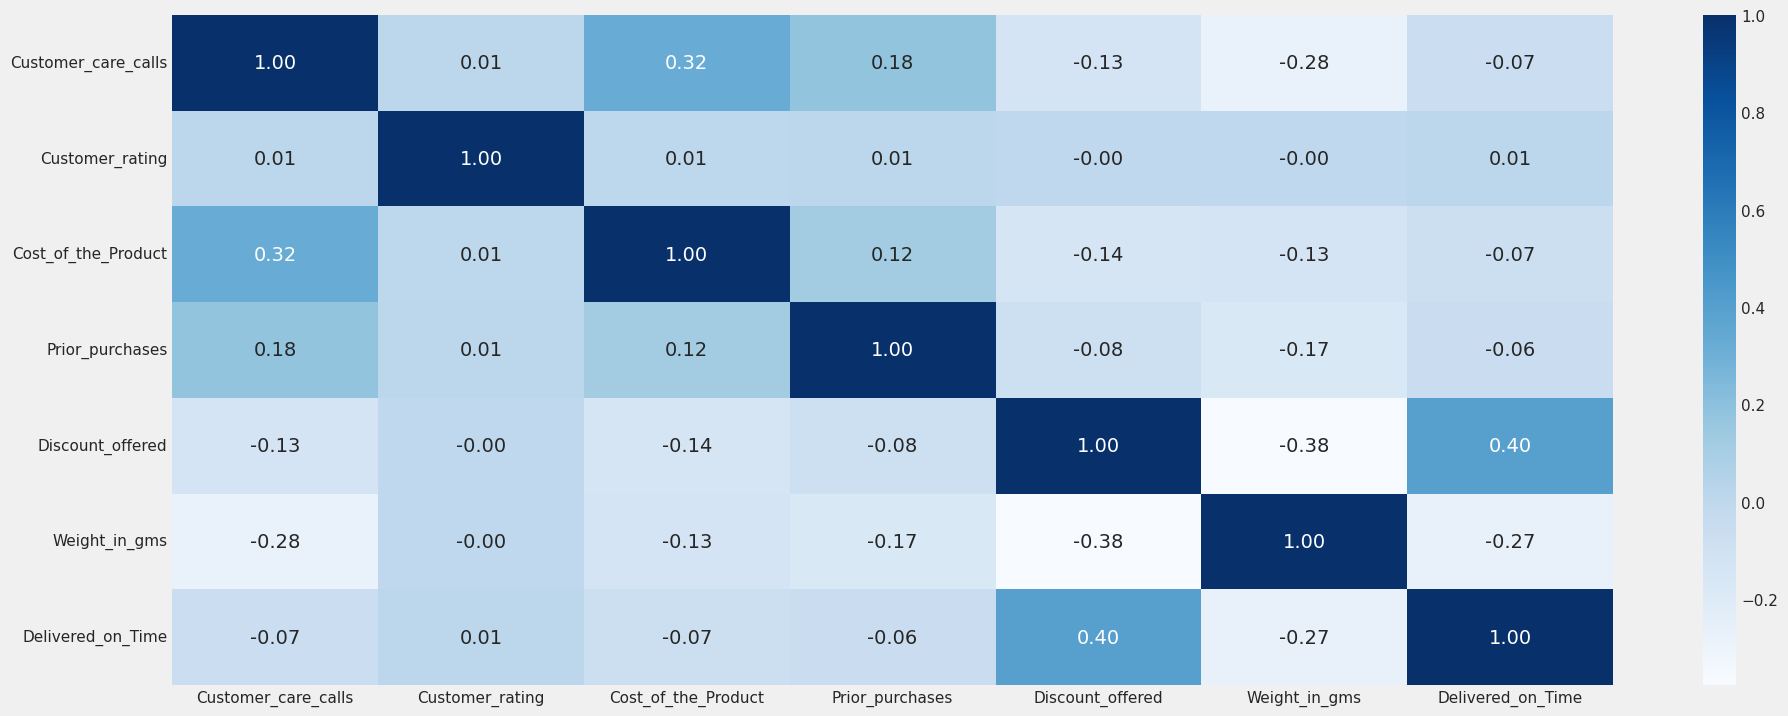

In [24]:
#kolom id dihilangkan dari analisis univariate dan multivariate
df_copy = df.copy() #df_copy sebagai dataframe baru (tanpa kolom id) untuk analisis heatmap
del df_copy['ID'] #menghapus kolom id pada df_corr untuk analisis heatmap
sns.heatmap(df_copy.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show()

- Feature Discount_offered berkorelasi positif lemah terhadap target (0.40), sehingga semakin tinggi diskon, semakin tinggi pula kecenderungan untuk barang tidak sampai tepat waktu.
- Feature Weight_in_gms (berat barang) berkorelasi negatif lemah terhadap target (-0.27), sehingga semakin berat barang, semakin tinggi kecenderungan barang untuk terkirim tepat waktu.
- Terdapat korelasi positif lemah antara Customer_care_calls dengan Cost_of_the_Product (0.32). Semakin tinggi harga barang, semakin tinggi pula jumlah customer care calls yang diterima.
- Terdapat korelasi negatif lemah antara Weight_in_gms dengan Discount_offered (-0.38). Semakin tinggi berat barang, semakin kecil nilai diskon yang diberikan.
- Feature lainnya tidak memiliki korelasi secara linier baik dengan antar fitur dan dengan target.

### Korelasi Antar Feature dengan Target

### Pair Plot

In [25]:
#plt.figure(figsize=(5, 5))
#sns.pairplot(df_copy, diag_kind='kde', hue = 'Delivered_on_Time')

- Dari pairplot, didapatkan beberapa hubungan yang menarik (yang cukup terpisah pada variable targetnya) yaitu pada Discount_offered, Cost_of_the_Product, dan Weight_in_gms. Ketiga fitur ini memiliki nilai yang cukup terpisah dengan target, sehingga sangat relevan untuk dipertahankan sebagai fitur pada saat modelling. Ketiga fitur ini akan dianalisis lebih lanjut korelasinya dengan feature kategorikal.
- **Semua barang di antara 2000 hingga 4000 gram dan harga barang yang berada di antara 175 hingga 300 tidak terkirim tepat waktu.**
- **Barang dengan berat di bawah 2000 gram dan harga barang sekitar 100 - 125, tidak terkirim tepat waktu.**
- **Semua barang yang mendapatkan diskon >10% tidak terkirim tepat waktu, berapapun berat dan harga barangnya.**
- Semua barang dengan berat di atas 6000 gram tidak terkirim tepat waktu.

### Sebaran Feature Numerical (Discount_offered) dengan Feature Categorical (Warehouse_block, Mode_of_Shipment, Product_importance, dan Gender) pada Target

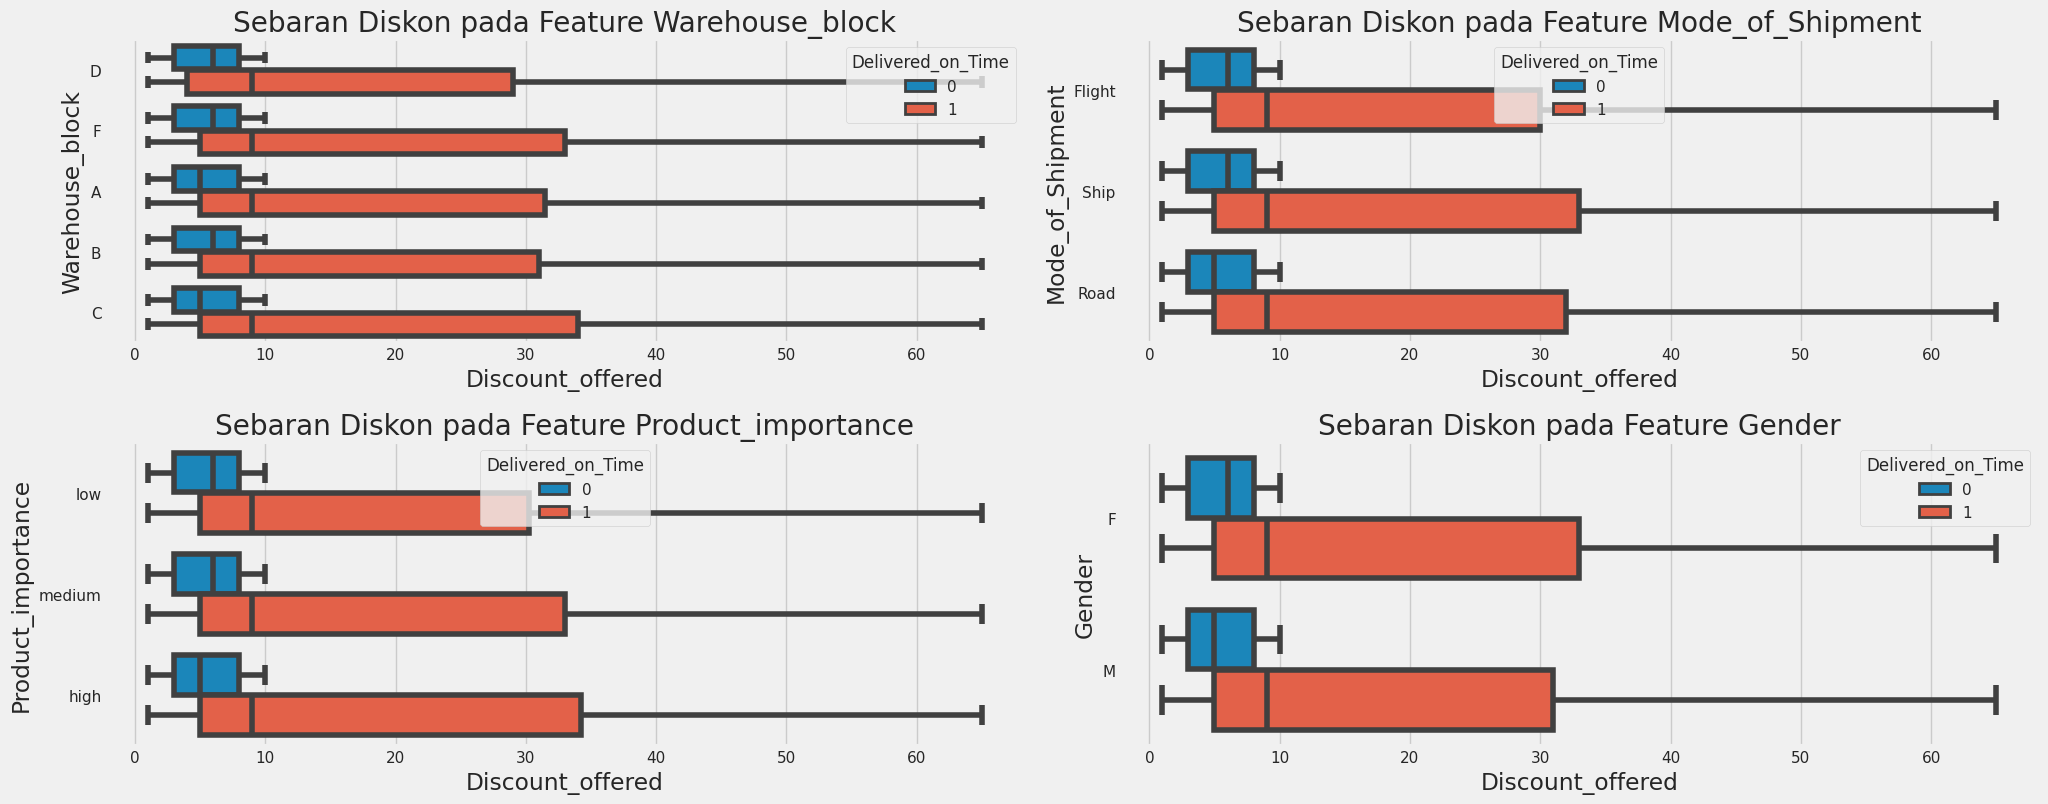

In [26]:
for i in range(0, len(categorical)):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df[categorical[i]], x='Discount_offered', showfliers = False, data=df, hue='Delivered_on_Time')
    plt.title(f'Sebaran Diskon pada Feature {categorical[i]}')
    plt.tight_layout()

*   Warehouse block A memberikan diskon yang cenderung lebih sedikit dibandingkan dengan Warehouse block lainnya, mengkonfirmasi pengamatan sebelumnya dimana Warehouse block A lebih tepat waktu dalam pengiriman barang.
*   Mode_of_Shipment tipe Road memberikan diskon yang lebih kecil dibandingkan dengan tipe Flight dan Ship, dimana hal ini mengkonfirmasi mode Road menjadi metode yang paling banyak mengirimkan barang tepat waktu.
*   Sebagian barang dengan diskon < 10% tidak mengalami keterlambatan pengiriman pada feature Warehouse_block, Product_importance, Mode_of_Shipment, maupun Gender.
*   Sementara barang dengan diskon > 10% semuanya mengalami keterlambatan.








## Business Insight

1. Diskon Tinggi Berkorelasi Positif dengan Pengiriman Tidak Tepat Waktu.
2. Berat Barang dan Harga Barang berpengaruh pada Pengiriman Tepat Waktu.
3. Product importance ‘high’ berpengaruh pada barang dengan Pengiriman Barang Tidak Tepat Waktu

# Data Pre-Processing

## Handling Missing Value

In [27]:
df.isna().any()

ID                     False
Warehouse_block        False
Mode_of_Shipment       False
Customer_care_calls    False
Customer_rating        False
Cost_of_the_Product    False
Prior_purchases        False
Product_importance     False
Gender                 False
Discount_offered       False
Weight_in_gms          False
Delivered_on_Time      False
dtype: bool

Tidak ditemukan missing value pada dataset.

## Handling Duplicate Data

In [28]:
df.duplicated().any()

False

Tidak terdapat duplicate data pada dataset.

## Handling Invalid Values

In [29]:
df.describe(include='all')

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Delivered_on_Time
count,10999,10999,10999,10999.000000,10999.000000,10999.000000,10999.000000,10999,10999,10999.000000,10999.000000,10999.000000
unique,10999,5,3,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN
top,1,F,Ship,NaN,NaN,NaN,NaN,low,F,NaN,NaN,NaN
freq,1,3666,7462,NaN,NaN,NaN,NaN,5297,5545,NaN,NaN,NaN
mean,NaN,NaN,NaN,4.054459,2.990545,210.196836,3.567597,NaN,NaN,13.373216,3634.016729,0.596691
std,NaN,NaN,NaN,1.141490,1.413603,48.063272,1.522860,NaN,NaN,16.205527,1635.377251,0.490584
min,NaN,NaN,NaN,2.000000,1.000000,96.000000,2.000000,NaN,NaN,1.000000,1001.000000,0.000000
25%,NaN,NaN,NaN,3.000000,2.000000,169.000000,3.000000,NaN,NaN,4.000000,1839.500000,0.000000
50%,NaN,NaN,NaN,4.000000,3.000000,214.000000,3.000000,NaN,NaN,7.000000,4149.000000,1.000000
75%,NaN,NaN,NaN,5.000000,4.000000,251.000000,4.000000,NaN,NaN,10.000000,5050.000000,1.000000


Dilihat dari semua features yang ada, tidak terdapat nilai invalid yang ditemukan dari data statistik dan nilai unique value, yang telah dicek pada tahap EDA.

## Feature Extraction

Sebelum melakukan lebih jauh data preprocessing, dilakukan terlebih dahulu feature extraction dan selection, sehingga feature yang dikurangi/ditambahkan dapat ikut diolah pada proses data preprocessing selanjutnya.

Berdasarkan hasil EDA pada feature Weight_in_gms, distribusi berat barang yang ada pada dataset memiliki distribusi bimodal. Karena itu, dilakukan feature extraction dari feature Weight_in_gms untuk mengelompokkan berat barang menjadi 4 kategori:
1. Berat barang <= 2000 g
2. Berat barang pada 2001 - 4000 g
3. Berat barang pada 4001 - 6000 g
2. Berat barang > 6000 g


In [30]:
def weight_class(category):

    if category <= 2000:
        return 0
    elif category <= 4000:
        return 1
    elif category <= 6000:
        return 2
    else:
        return 3

In [31]:
#klasifikasi berat barang
df['Weight_class'] = df['Weight_in_gms'].apply(lambda x: weight_class(x))
df.sample(10)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Delivered_on_Time,Weight_class
37,38,F,Ship,2,4,181,6,medium,F,16,3605,1,1
10409,10410,F,Flight,6,2,271,4,low,F,2,1893,1,0
4985,4986,F,Ship,6,1,152,2,low,F,3,1340,0,0
1510,1511,C,Flight,3,4,245,4,low,M,20,2534,1,1
445,446,F,Ship,4,4,189,2,medium,F,18,2955,1,1
6553,6554,F,Road,4,1,264,6,low,M,7,1007,0,0
2363,2364,F,Ship,5,5,141,2,medium,M,14,1114,1,0
8873,8874,F,Ship,7,1,307,4,low,M,2,1983,0,0
7406,7407,A,Flight,7,5,289,4,low,M,10,1385,0,0
6068,6069,A,Ship,4,1,224,4,medium,F,5,4887,0,2


## Feature Selection

Feature selection dilakukan berdasarkan 3 metode:
1. Melihat korelasi antar feature yang kuat (multicolinearity)
2. Melihat feature yang memiliki low variance (data numerik) dan low entropy (data kategorikal).
3. Menghitung nilai Weight of Evidence (WoE) dan Information Value (IV) pada masing-masing feature untuk mengetahui kekuatan pengaruh tiap feature dalam memprediksi nilai target.

### Feature Selection Metode 1

Feature Selection Metode 1 dilakukan dengan melihat korelasi antar fitur dan fitur dengan target.

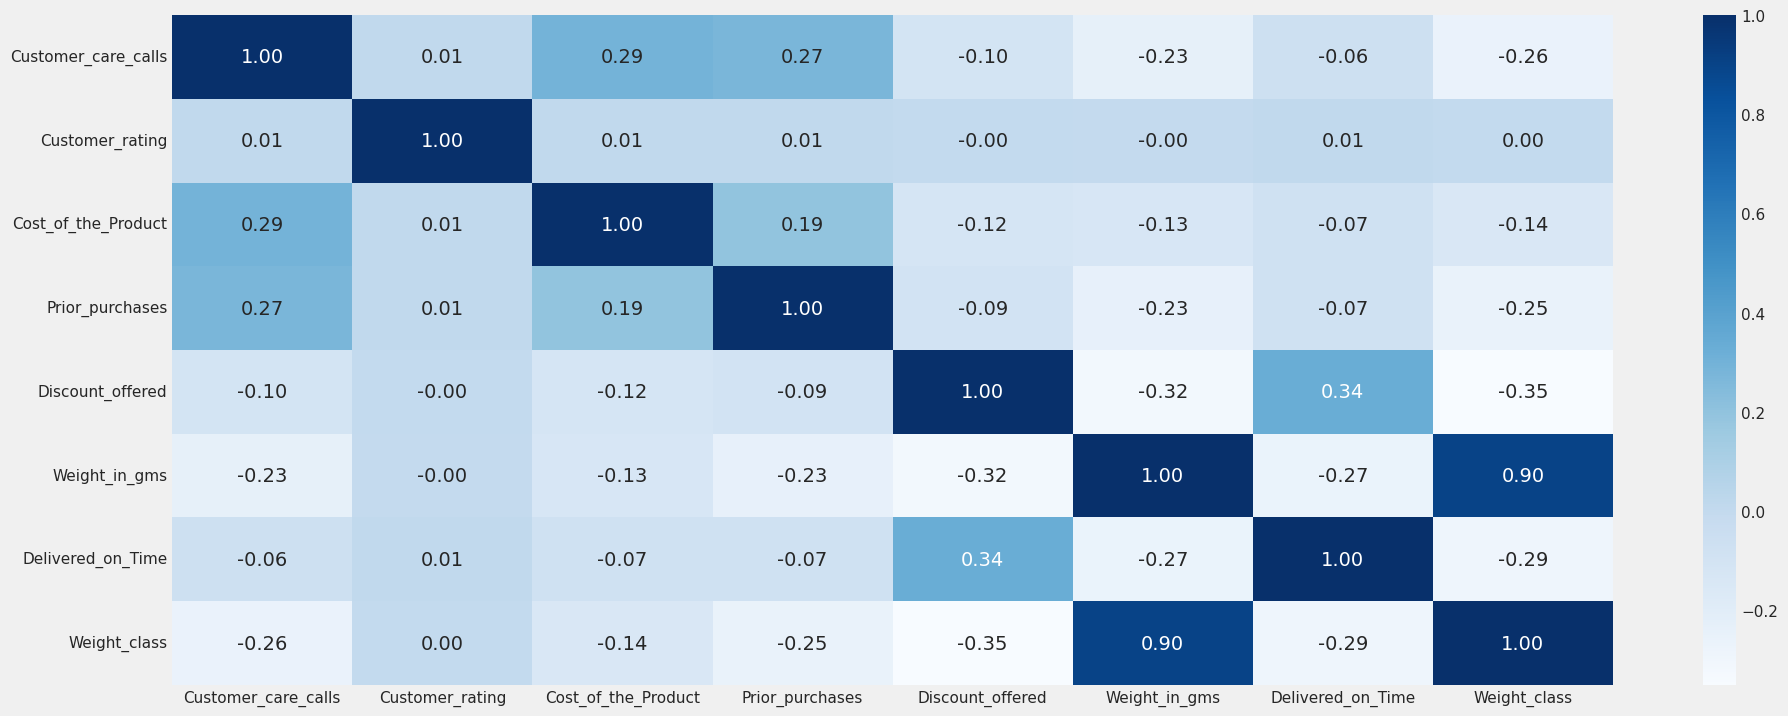

In [32]:
df_copy = df.copy() #df_copy sebagai dataframe baru (tanpa kolom id) untuk analisis heatmap
del df_copy['ID'] #menghapus kolom id pada df_corr untuk analisis heatmap
sns.heatmap(df_copy.corr(method = 'spearman'), cmap='Blues', annot=True, fmt='.2f')
plt.show()

- Feature Weight_in_gms dan Weight_class memiliki berkorelasi secara kuat (0.95), sehingga diputuskan untuk menghilangkan feature Weight_in_gms.
- Nilai korelasi Weight_class dengan Delivered_on_Time lebih tinggi (-0.29) dibandingkan dengan nilai korelasi Weight_in_gms dengan Delivered_on_Time (-0.27).
- Penghilangan fitur Weight_in_gms dilakukan untuk menghilangkan efek multicolinearity.  

In [33]:
df = df.drop('Weight_in_gms', axis = 1)

### Feature Selection Metode 2

Feature Selection Metode 2 dilakukan dengan melihat sebaran nilai pada dataset untuk mengetahui apakah ada feature yang memiliki low variance atau low entropy.

In [34]:
numerical = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_class']

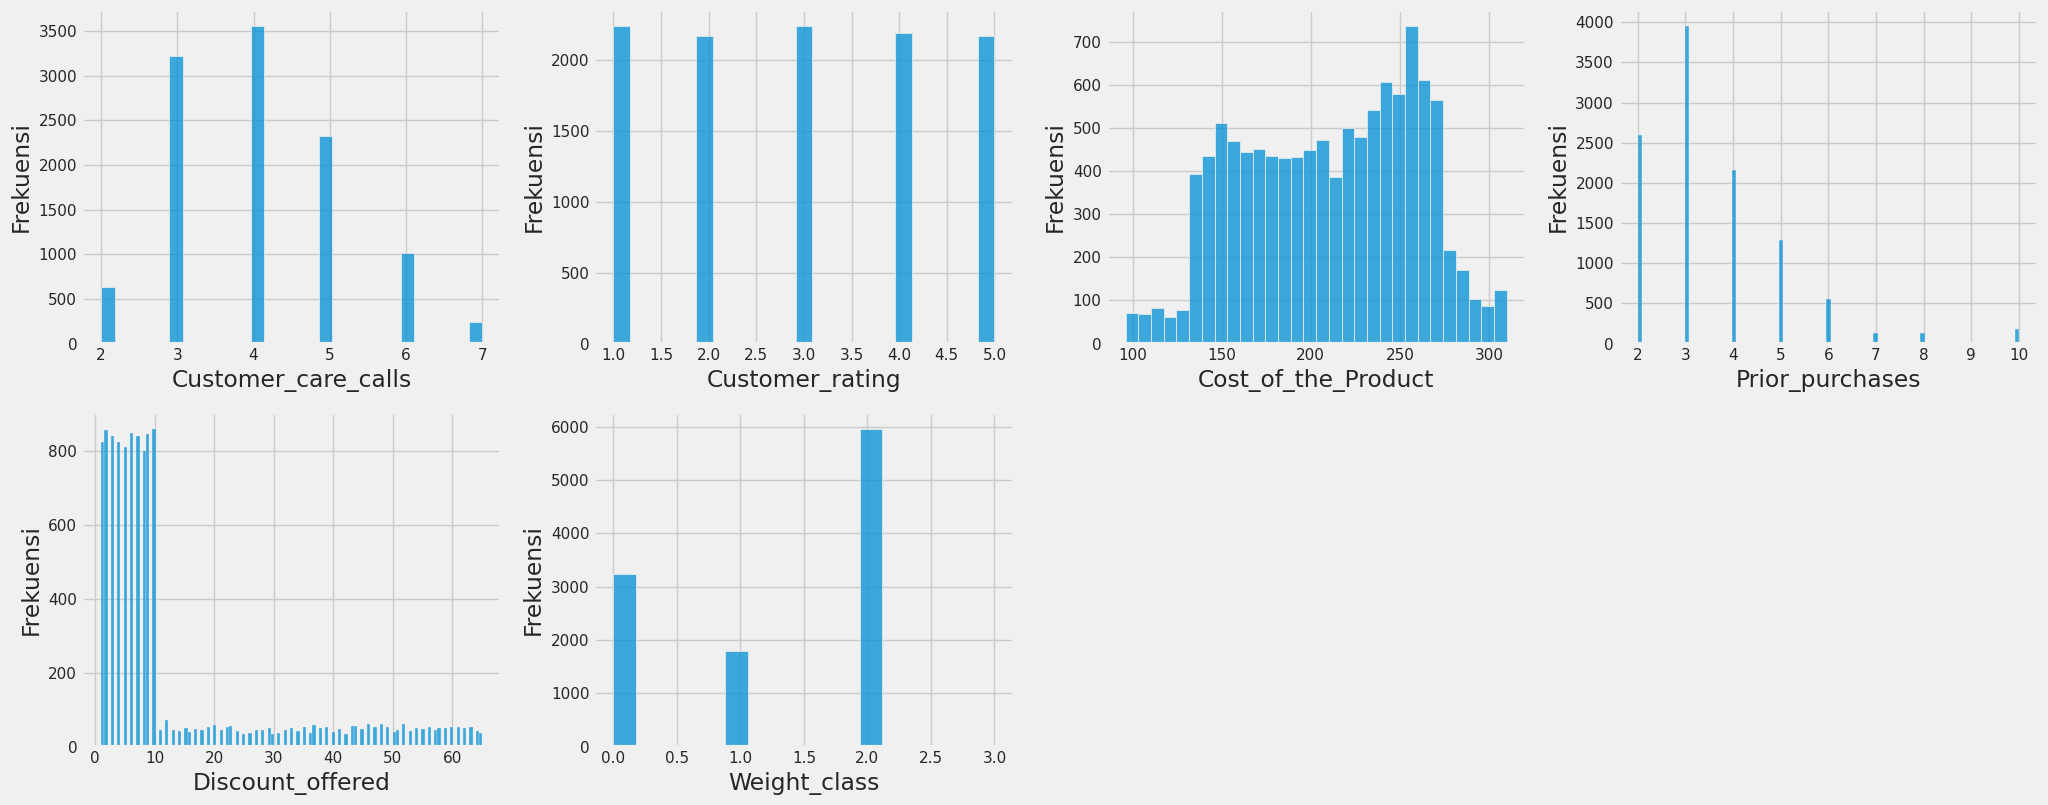

In [35]:
for i in range(0, len(numerical)):
    plt.subplot(2, 4, i+1)
    sns.histplot(x=df[numerical[i]], data = df)
    plt.ylabel('Frekuensi')
    plt.tight_layout()

- Keenam feature numerik tidak memiliki low variance, sehingga feature selection belum dapat dilakukan dengan Metode 2.

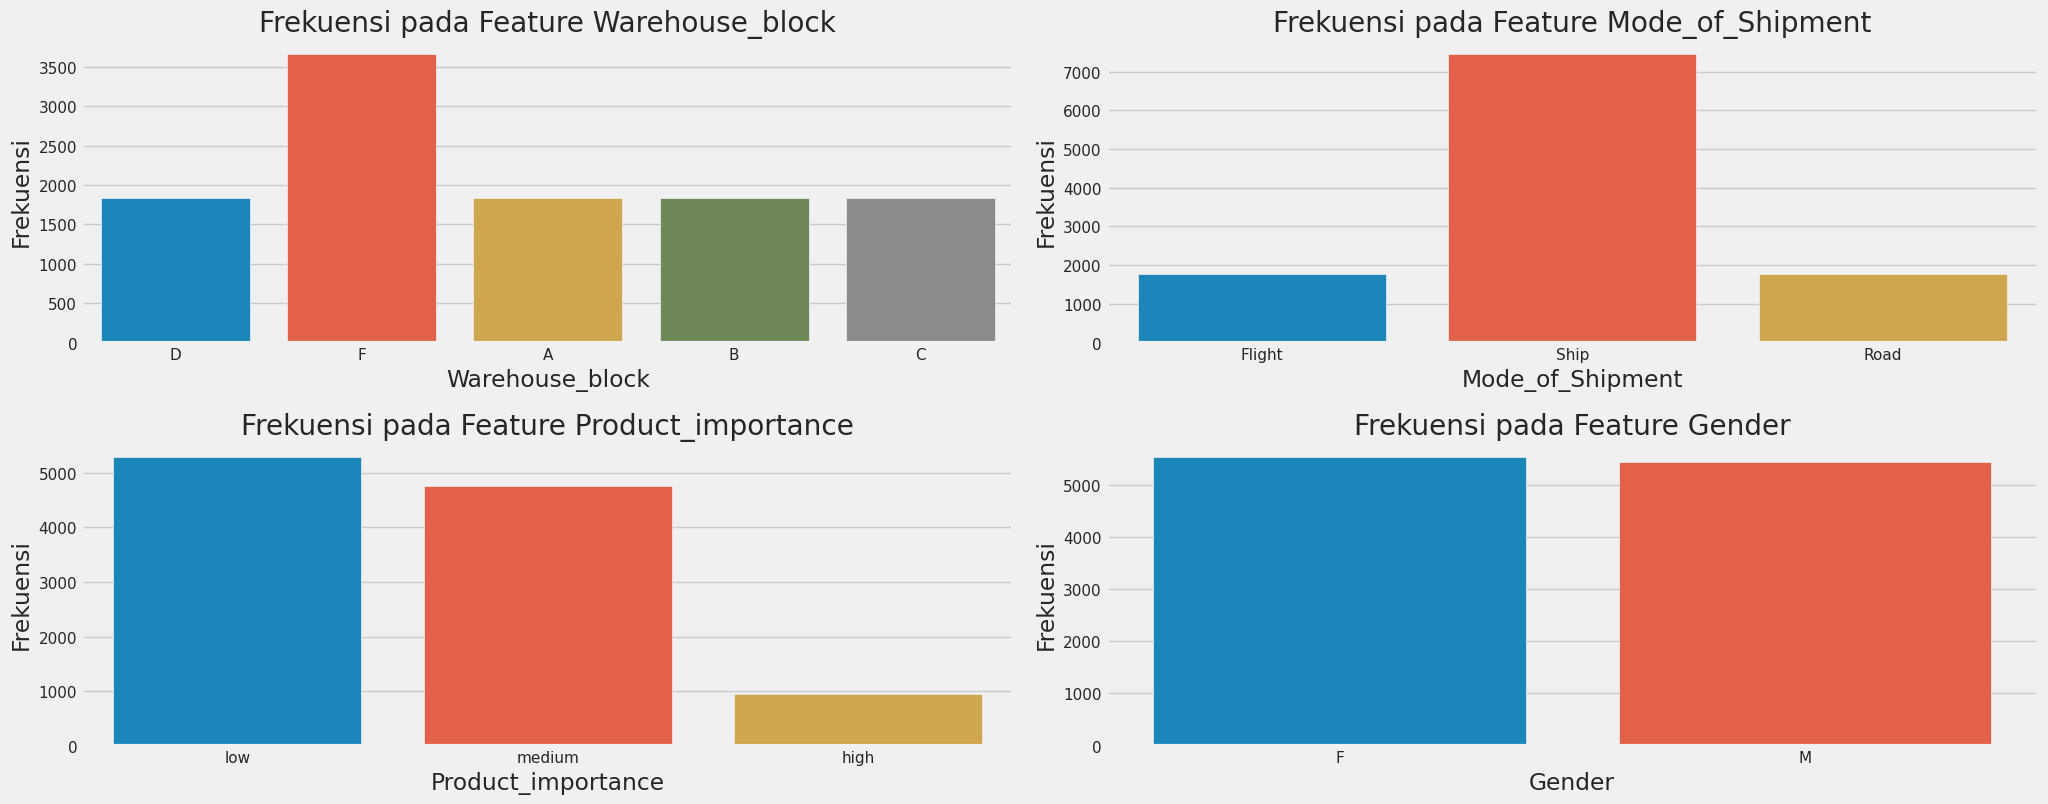

In [36]:
for i in range(0, len(categorical)):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=df[categorical[i]])
    plt.title(f'Frekuensi pada Feature {categorical[i]}')
    plt.ylabel('Frekuensi')
    plt.tight_layout()

- Dari keempat feature kategorikal yang ada, tidak ada feature yang berpusat pada 1 kategori memiliki low entropy, sehingga feature selection belum dapat dilakukan pada feature kategorikal dengan Metode 2.

### Feature Selection Metode 3

*   Feature selection Metode 3 dilakukan dengan analisis nilai Weight of Evidence (WoE) dan Infomation Value (IV). Tabel yang menunjukkan nilai prediksi berdasarkan Information Value ditunjukkan pada gambar berikut.

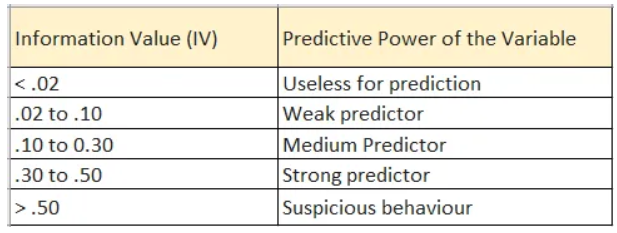









In [37]:
list_column_raw = list(df.columns)
drop_column_bin = ['ID', 'Delivered_on_Time']

list_column = [i for i in list_column_raw if i not in drop_column_bin]

x_bin = df[list_column]
y_bin = df.Delivered_on_Time

In [38]:
#Start Binning for WoE
binning_fit_params = dict.fromkeys(list_column, {'monotonic_trend': 'auto_asc_desc',\
                                                  'min_n_bins':2, 'max_n_bins':10})
binning_process    = BinningProcess(list_column, binning_fit_params=binning_fit_params)
binning_process.fit(x_bin, y_bin)

appended_data = []
for i in list_column:
    optb = binning_process.get_binned_variable(i)

    # store DataFrame in list
    data = optb.binning_table.build()
    data['features'] = i
    appended_data.append(data)
appended_data = pd.concat(appended_data)

features = binning_process.summary()[binning_process.summary()['selected'] == True]['name'].tolist()
woe = appended_data.copy()

woe['% of Event']     = np.maximum(woe['Event'], 0.5) / y_bin[y_bin == 1].shape[0]
woe['% of Non-event'] = np.maximum(woe['Non-event'], 0.5) / y_bin[y_bin == 0].shape[0]

# Transform Binning Value to WoE

data_transform = binning_process.transform(x_bin, metric='woe')
data_transform['Delivered_on_Time'] = df['Delivered_on_Time']

# Nilai IV merupakan nilai sum dari IV setiap bin
summary_woe_iv = binning_process.summary()
summary_woe_iv.sort_values('iv', ascending = False)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
8,Discount_offered,numerical,OPTIMAL,True,2,0.727921,0.085013,0.36095,0.323539
9,Weight_class,numerical,OPTIMAL,True,2,0.598112,0.072643,0.371321,0.526345
5,Prior_purchases,numerical,OPTIMAL,True,3,0.036455,0.004549,0.094644,0.027663
4,Cost_of_the_Product,numerical,OPTIMAL,True,7,0.026988,0.003364,0.090206,0.00559
2,Customer_care_calls,numerical,OPTIMAL,True,5,0.020348,0.002535,0.072987,0.040471
6,Product_importance,categorical,OPTIMAL,True,3,0.004722,0.000589,0.02104,0.002653
3,Customer_rating,numerical,OPTIMAL,True,4,0.001005,0.000126,0.016938,0.000024
0,Warehouse_block,categorical,OPTIMAL,True,5,0.000411,0.000051,0.009798,0.0
1,Mode_of_Shipment,categorical,OPTIMAL,True,3,0.00028,0.000035,0.007562,0.000093
7,Gender,categorical,OPTIMAL,True,2,0.000091,0.000011,0.004779,0.000096


Berdasarkan nilai pada kolom iv, didapatkan **nilai diatas 0,5** pada feature **Discount_offered dan Weight_class**. Kedua feature ini dikategorikan sebagai feature dengan **suspicious behavior** atau diduga berkorelasi sangat tinggi dengan target. Karena jumlah feature pada dataset tidak terlalu banyak, maka diputuskan untuk mempertahankan feature yang masuk dalam kategori ini.
*   Feature **Product_importance, Customer_rating, Warehouse_block,	Mode_of_Shipment, dan Gender** memiliki nilai iv < 0,02, dimana feature yang masuk kategori ini tidak signifikan untuk digunakan pada proses modeling. Feature yang masuk dalam kategori ini akan dihilangkan, kecuali feature **Product_importance**, karena pada proses EDA ditemukan bahwa feature ini memiliki pengaruh terhadap target.\
- Feature yang akan digunakan adalah:
1. Discount_offered
2. Weight_class
3. Prior_purchases
4. Cost_of_the_Product
5. Customer_care_calls
6. Product_importance

## Feature Encoding

Terdapat 1 feature bertipe kategorikal pada dataset, yaitu Product_importance. Sebelum melanjutkan data preprocessing, dilakukan terlebih dahulu feature encoding.

Akan dilakukan teknik Label Encoding untuk Feature Encoding pada feature Product_importance, karena Product_importance merupakan feature kategorikal yang bertipe ordinal.

In [39]:
#label encoding untuk product importance
df['Product_importance'] = df['Product_importance'].map({'low' : 0, 'medium': 1, 'high': 2})

## Handling Outlier

Sebelum dilakukan data preprocessing lebih lanjut, dataset akan di split menjadi data train dan data test, untuk menghindari data leakage dari data train ke data test.

In [40]:
# memisahkan kolom feature dan target
X= df[['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases','Product_importance', 'Discount_offered','Weight_class']]
y= df[['Delivered_on_Time']]

In [41]:
# pemisahan data train dan data test dengan proporsi 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [42]:
X_train.shape

(8799, 6)

In [43]:
X_test.shape

(2200, 6)

In [44]:
X_test['Cost_of_the_Product'].sum() # untuk keperluan business simulation

460926

In [45]:
X_test[X_test['Discount_offered']>10].median() # untuk keperluan business simulation

Customer_care_calls      4.0
Cost_of_the_Product    196.0
Prior_purchases          3.0
Product_importance       1.0
Discount_offered        38.0
Weight_class             1.0
dtype: float64

In [46]:
X_test.groupby(X_test['Discount_offered']>10).count() # untuk keperluan business simulation

,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_class
Discount_offered,,,,,,
False,1671,1671,1671,1671,1671,1671
True,529,529,529,529,529,529


In [47]:
numerical = ['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_class', 'Product_importance']

### Pengamatan feature numerik (data train) sebelum handling outlier

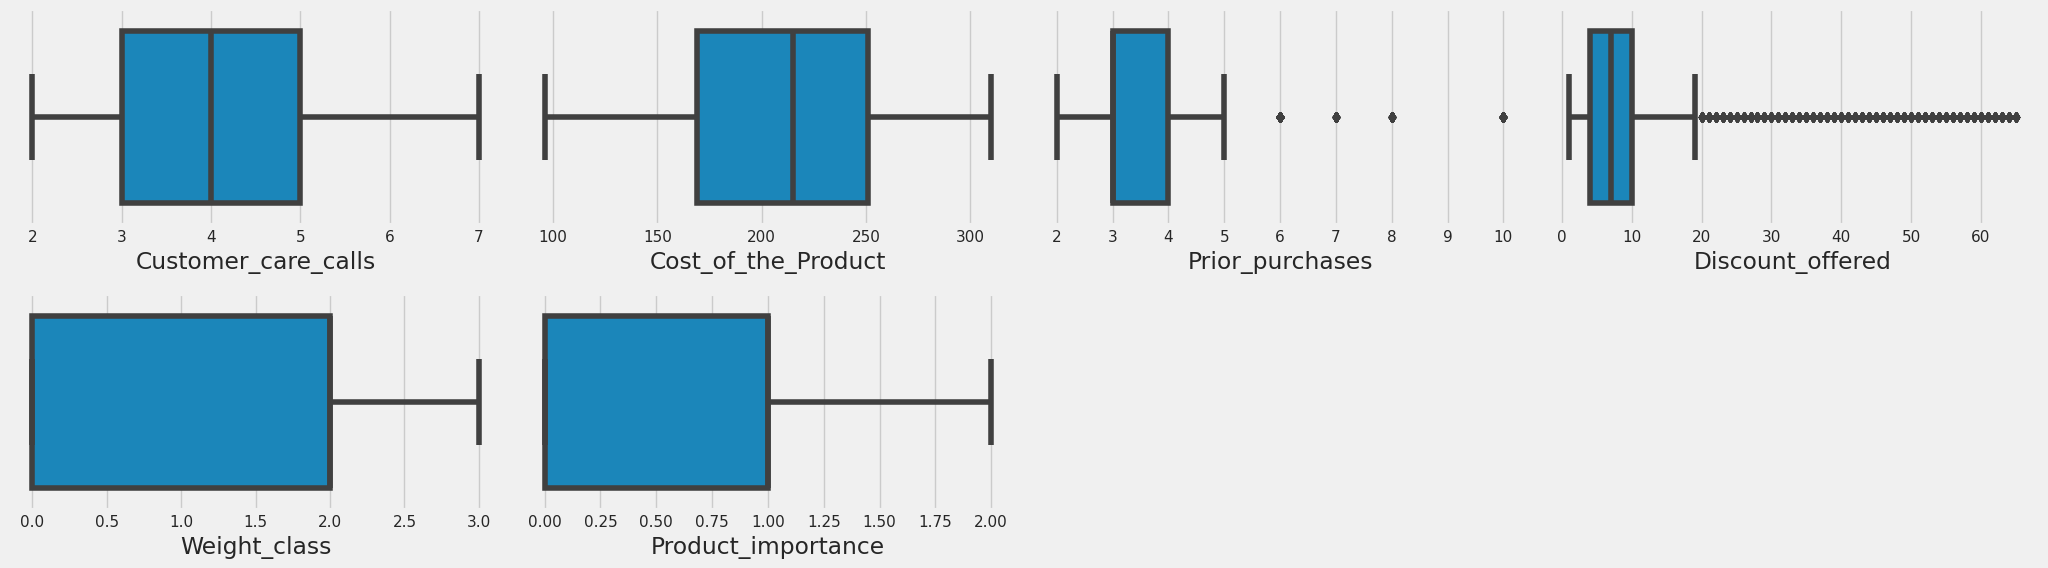

In [48]:
for i in range(0, len(numerical)):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x=X_train[numerical[i]])
    plt.tight_layout()

Dilihat dari sebaran feature pada dataset, feature Prior_purchases memiliki global outlier pada nilai 10. Dilakukan pengecekan pada jumlah data yang memiliki Prior_purchases = 10.

In [49]:
X_train[X_train['Prior_purchases']==10]

,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_class
2067,2,225,10,2,46,1
8589,3,195,10,0,9,2
9084,2,204,10,0,1,2
6794,4,134,10,1,8,2
4084,3,273,10,1,10,2
...,...,...,...,...,...,...
1150,3,148,10,2,12,0
6799,3,265,10,0,10,2
7385,3,146,10,0,5,2
2558,4,162,10,2,25,0


Dilihat dari jumlah data orang dengan prior purchases sebanyak 151. Jumlah data cukup banyak apabila dihilangkan sebagai outlier, maka diputuskan untuk tidak menghilangkan data dengan Prior_purchases =10.

Sebaran feature lain pada data train tidak ditemukan global outlier (hanya ada collective outlier), maka diputuskan untuk tidak melakukan handling pada outlier yang ditemukan. Dataset nantinya akan langsung ditransformasi dengan metode transformasi yang robust terhadap outlier untuk mendapatkan distribusi normal.  

## Feature Transformation

In [50]:
X_train1 = X_train.copy() #variabel sementara untuk trial dan error proses transformasi data

In [51]:
X_test1 = X_test.copy()

Dilakukan transformasi data pada feature Cost_of_the_Product dan Discount_offered dengan metode Quantile Transformation. Feature lain tidak dilakukan transformasi data, karena feature memiliki nilai diskrit.

In [52]:
# membuat fungsi untuk transformasi
def transformation(data):
  transformed_data = data.copy()
  transformed_data['Discount_offered'] = transform_Discount_offered.transform(data['Discount_offered'].values.reshape(-1, 1))
  transformed_data['Cost_of_the_Product'] = transform_Cost_of_the_Product.transform(data['Cost_of_the_Product'].values.reshape(-1, 1))
  return transformed_data

In [53]:
# Data Transformation

transform_Discount_offered = QuantileTransformer(output_distribution = 'normal', random_state = 42)
transform_Cost_of_the_Product = QuantileTransformer(output_distribution = 'normal', random_state = 42)

transform_Discount_offered.fit(X_train1['Discount_offered'].values.reshape(-1, 1))
transform_Cost_of_the_Product.fit(X_train1['Cost_of_the_Product'].values.reshape(-1, 1))

X_train_transformation = transformation(X_train1)
X_test_transformation = transformation(X_test1)


### Perbandingan Sebelum dan Sesudah Data Transformation

### Transformasi Data Train

In [54]:
# list kolom yang dilakukan data transformation
list_transformation = ['Discount_offered', 'Cost_of_the_Product']

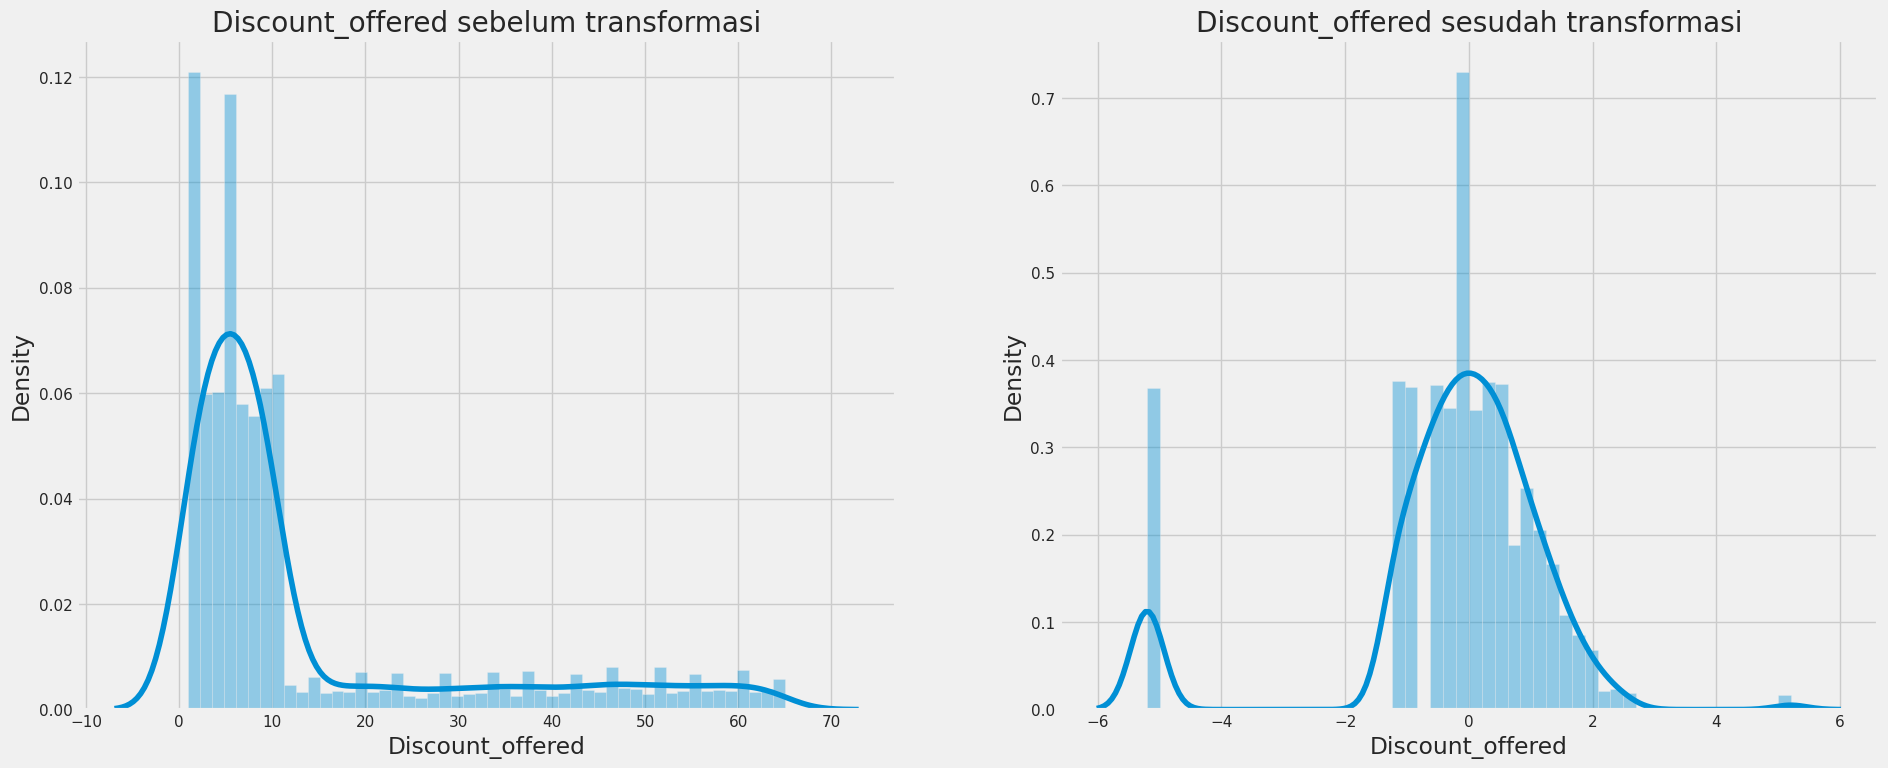

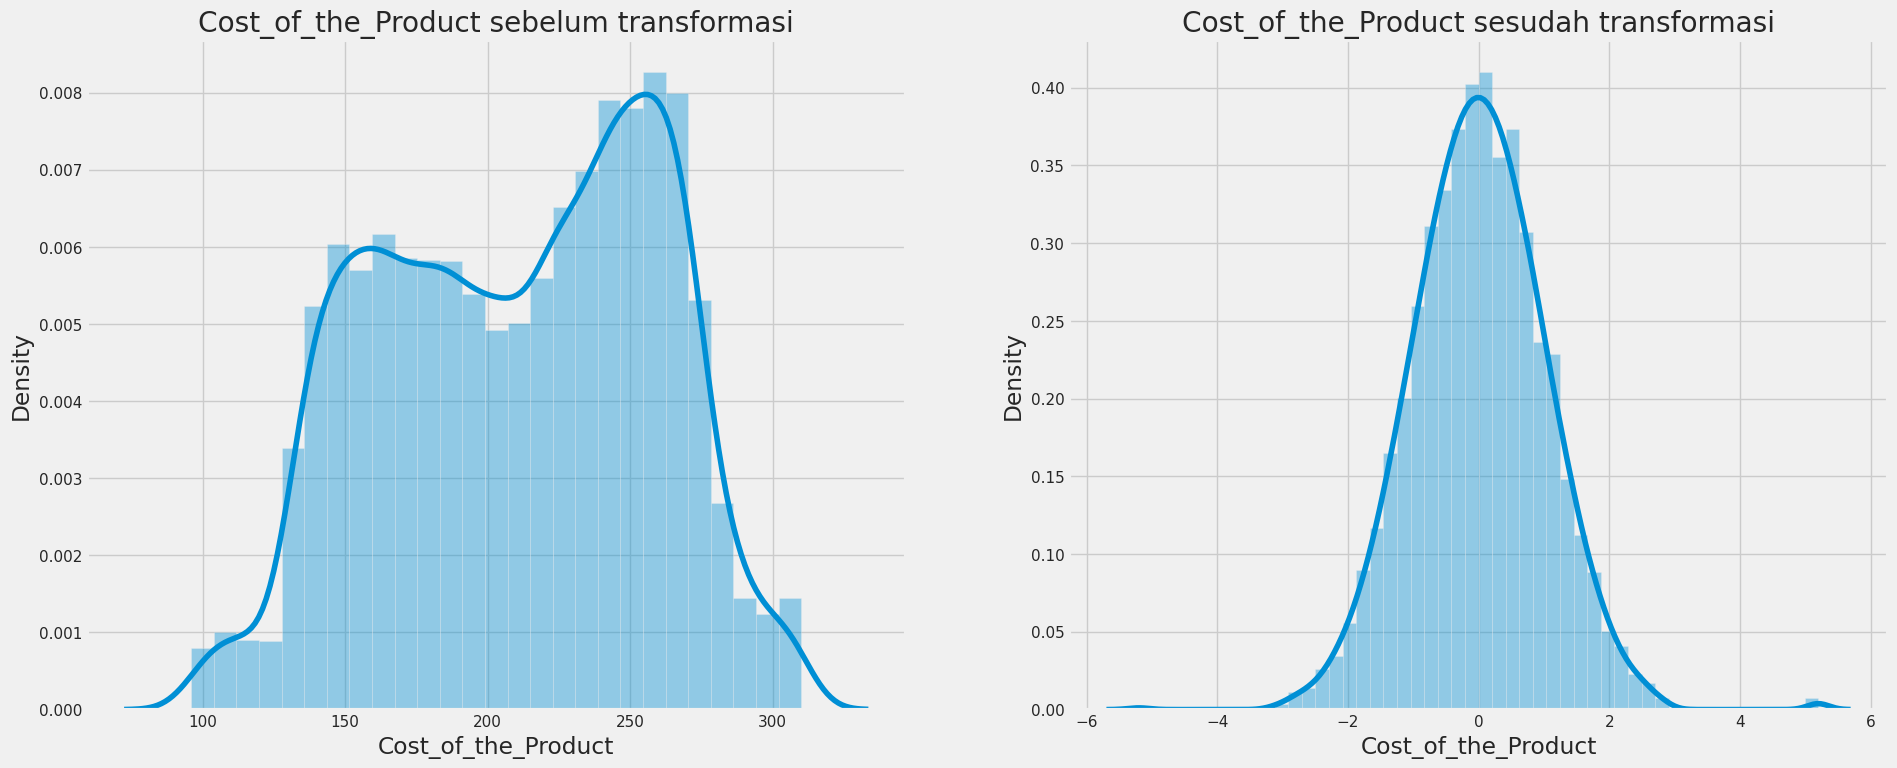

In [55]:
X_train_transformation = pd.DataFrame(X_train_transformation,columns= numerical)

for col in list_transformation:
    plt.subplot(121)
    sns.distplot(X_train1[col])
    plt.title(f'{col} sebelum transformasi')

    plt.subplot(122)
    sns.distplot(X_train_transformation[col])
    plt.title(f'{col} sesudah transformasi')
    plt.show()

### Transformasi Data Test

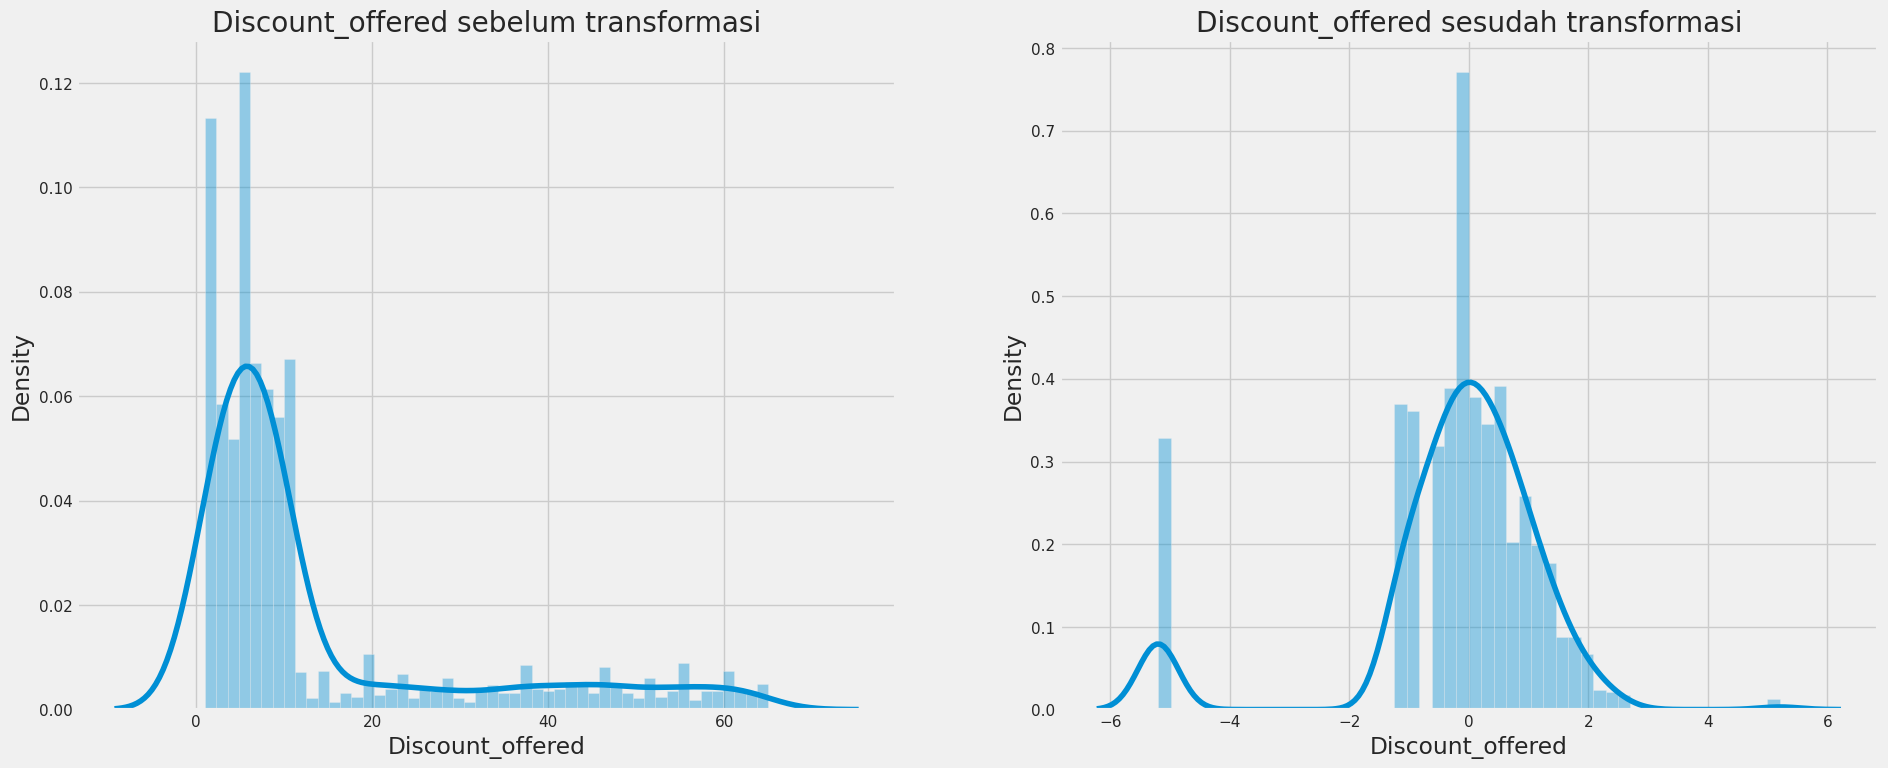

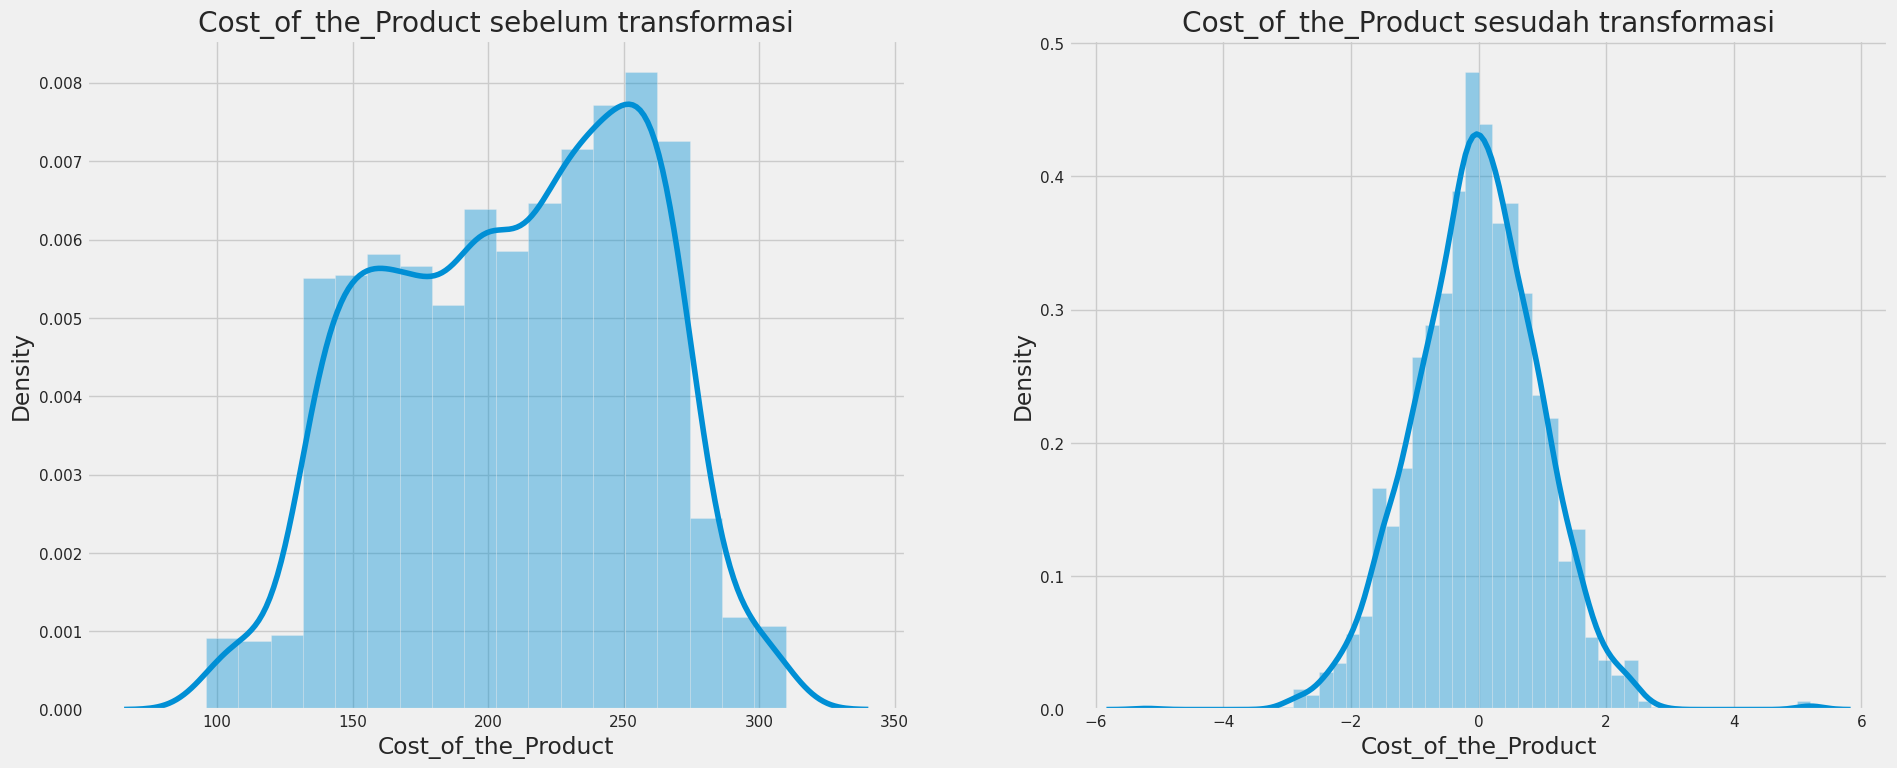

In [56]:
X_test_transformation = pd.DataFrame(X_test_transformation,columns = numerical)


for col in list_transformation:
    plt.subplot(121)
    sns.distplot(X_test1[col])
    plt.title(f'{col} sebelum transformasi')

    plt.subplot(122)
    sns.distplot(X_test_transformation[col])
    plt.title(f'{col} sesudah transformasi')
    plt.show()

In [57]:
# membuat fungsi untuk scaling
def scaling(data):
  scaling_data = data.copy()
  scaling_data['Discount_offered'] = scaling_Discount_offered.transform(data['Discount_offered'].values.reshape(-1, 1))
  scaling_data['Cost_of_the_Product'] = scaling_Cost_of_the_Product.transform(data['Cost_of_the_Product'].values.reshape(-1, 1))
  return scaling_data

In [58]:
# Data Scaling menggunakan StandardScaler

scaling_Discount_offered = StandardScaler()
scaling_Cost_of_the_Product = StandardScaler()

scaling_Discount_offered.fit(X_train_transformation['Discount_offered'].values.reshape(-1, 1))
scaling_Cost_of_the_Product.fit(X_train_transformation['Cost_of_the_Product'].values.reshape(-1, 1))

X_train_scaling = scaling(X_train_transformation)
X_test_scaling = scaling(X_test_transformation)

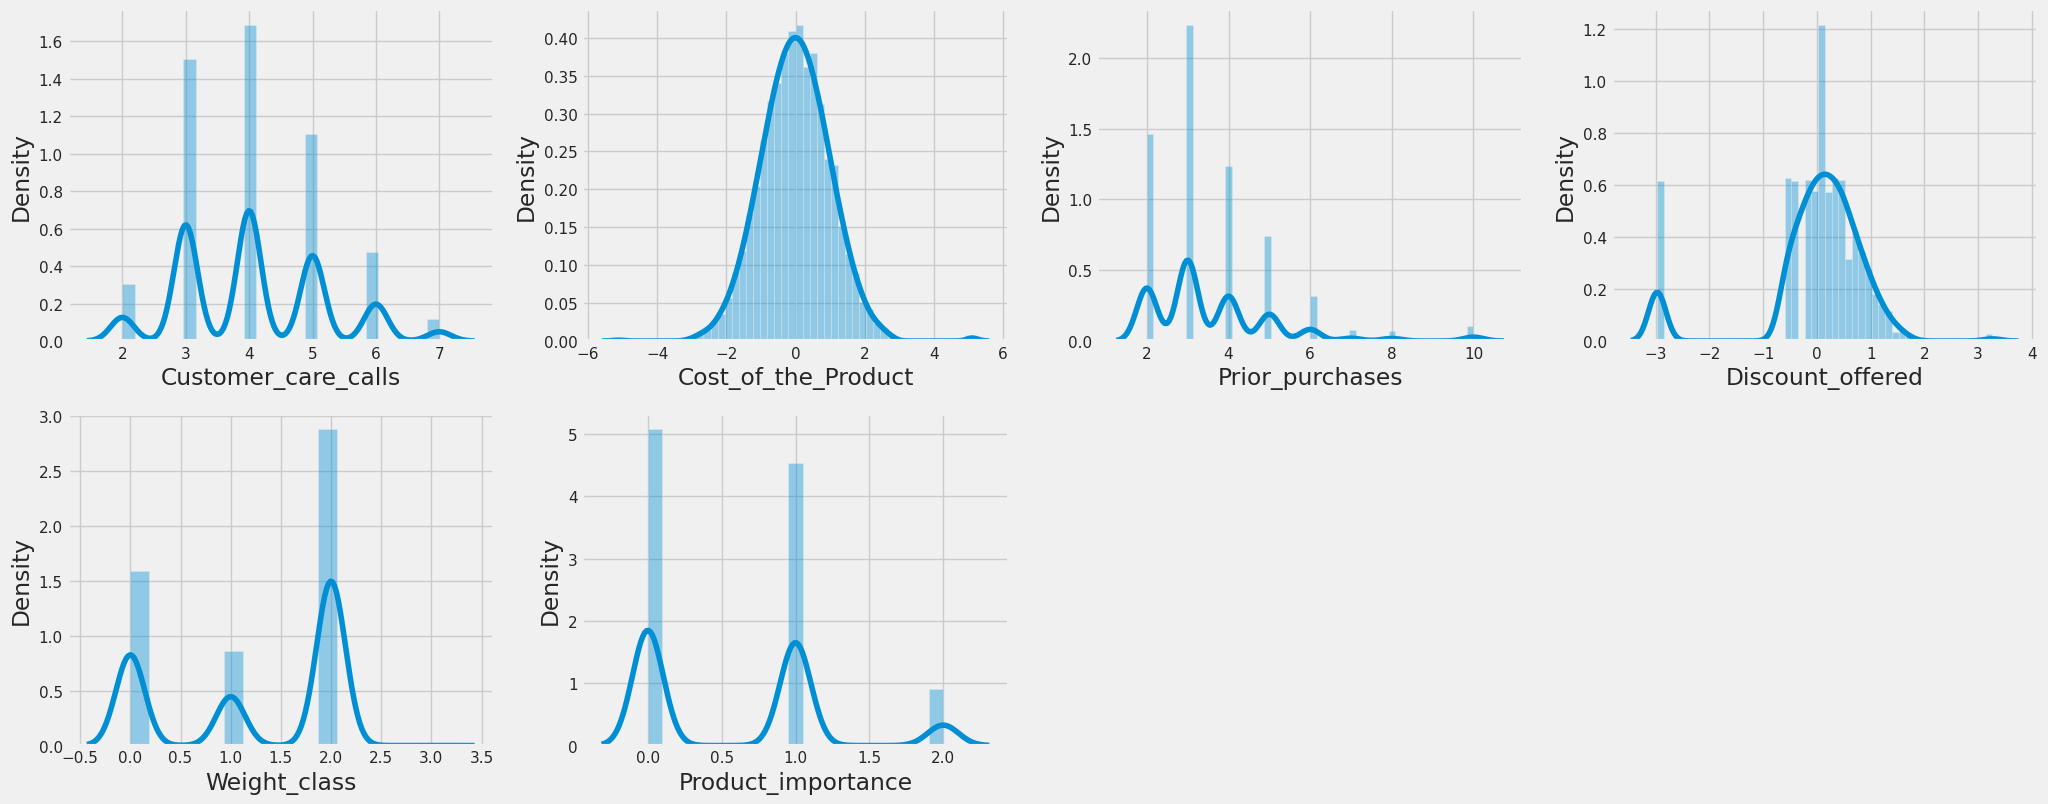

In [59]:
# Sebaran fitur setelah dilakukan scaling

for i in range(0, len(numerical)):
    plt.subplot(2, 4, i+1)
    sns.distplot(X_train_scaling[numerical[i]], kde = True)
    plt.tight_layout()

## Class Imbalance

In [60]:
percentage = round(df['Delivered_on_Time'].value_counts(normalize = True)*100,2)
print(percentage)

1    59.67
0    40.33
Name: Delivered_on_Time, dtype: float64


Dapat dilihat pada perbandingan nilai target (1: tidak terkirim tepat waktu dan 0: terkirim tepat waktu) memiliki perbandingan data 59.67: 40.33. Sehingga pada dataset ini tidak perlu dilakukan handling untuk class imbalance.

## Feature Tambahan

Feature tambahan yang berpotensi meningkatkan performansi model:
*   Tanggal Pengiriman (dapat dilakukan extraction pada tanggal (menjadi jam, hari, dll) agar didapatkan informasi tambahan terkait waktu traffic ramai, office hours, weekdays, weekend, atau waktu yang bersifat seasonal)
*   Jarak Pengiriman (untuk mengetahui estimasi waktu barang sampai)
*   Lokasi Penerima (untuk mengetahui estimasi waktu barang sampai)
*   Nama layanan ekspedisi pengiriman (misal JNE, JNT, Anteraja, dll)
*   Jenis Pengiriman (misalnya Same day delivery, Pengiriman dalam kota, Cargo, Express, Reguler, dll)







# Modeling

Split data train dan data test telah dilakukan pada proses EDA sebelumnya.

In [61]:
X_train = X_train_scaling.copy()
X_test = X_test_scaling.copy()

- Metriks evaluasi yang cocok pada kasus keterlambatan barang yaitu Recall dan ROC-AUC.
- Metriks Recall dipilih untuk meminimalkan jumlah 'miss' pada penanganan barang yang terlambat. Apabila nilai False Negative tinggi, maka akan banyak barang yang tidak diberikan perlakuan, dikarenakan hasil prediksi tidak terlambat, sedangkan pada aktualnya terlambat (false negative).
- Metriks ROC-AUC dipilih untuk menjaga agar model tetap dapat membedakan kelas positif dan negatif, sehingga tidak sepenuhnya berfokus pada metriks Recall. Meskipun metriks Recall menjadi metriks utama, namun metriks ROC-AUC tetap digunakan, karena False Positive yang dihasilkan oleh model pun berpotensi meningkatkan cost untuk perusahaan, sehingga nilai False Positive pun tetap harus dijaga.
- Dilakukan modeling dengan beberapa algoritma model untuk machine learning bertipe klasifikasi. Algoritma model yang digunakan yaitu Logistic Regression, KNN, DecisionTree, RandomForest, AdaBoost, XGBoost, dan CatBoost.


## Model Baseline Summary

In [62]:
models = [
    ['Logistic Regression', LogisticRegression(random_state=42)],
    ['KNN', KNeighborsClassifier()],
    ['Decision Tree', DecisionTreeClassifier(random_state=42)],
    ['Random Forest', RandomForestClassifier(random_state=42)],
    ['AdaBoost', AdaBoostClassifier(random_state=42)],
    ['XGB', XGBClassifier()],
    ['CatBoost', CatBoostClassifier(random_state = 42, verbose=False)]
]

def cross_validation(model):
    model_name = []

    cv_accuracy_train_mean = []
    cv_accuracy_test_mean = []
    cv_precision_train_mean = []
    cv_precision_test_mean = []
    cv_recall_train_mean = []
    cv_recall_test_mean = []
    cv_roc_auc_train_mean = []
    cv_roc_auc_test_mean = []

    for name, model in models:
        model_name.append(name)
        model.fit(X_train, y_train)
        #scoring
        scoring= ['accuracy', 'precision', 'recall', 'roc_auc']

        # test
        cv_score = cross_validate(model, X_train, y_train, cv=5, scoring = scoring, return_train_score=True)

        cv_accuracy_train_mean.append(cv_score['train_accuracy'].mean())
        cv_accuracy_test_mean.append(cv_score['test_accuracy'].mean())

        cv_precision_train_mean.append(cv_score['train_precision'].mean())
        cv_precision_test_mean.append(cv_score['test_precision'].mean())

        cv_recall_train_mean.append(cv_score['train_recall'].mean())
        cv_recall_test_mean.append(cv_score['test_recall'].mean())

        cv_roc_auc_train_mean.append((cv_score['train_roc_auc']).mean())
        cv_roc_auc_test_mean.append((cv_score['test_roc_auc']).mean())


    return pd.DataFrame({
        'Model': model_name,
        'CV Accuracy Train': cv_accuracy_train_mean,
        'CV Accuracy Test': cv_accuracy_test_mean,
        'CV Precision Train': cv_precision_train_mean,
        'CV Precision Test': cv_precision_test_mean,
        'CV Recall Train': cv_recall_train_mean,
        'CV Recall Test': cv_recall_test_mean,
        'CV ROC-AUC Train': cv_roc_auc_train_mean,
        'CV ROC-AUC Test': cv_roc_auc_test_mean
    })


In [63]:
cv_result = cross_validation(models)
cv_result

,Model,CV Accuracy Train,CV Accuracy Test,CV Precision Train,CV Precision Test,CV Recall Train,CV Recall Test,CV ROC-AUC Train,CV ROC-AUC Test
0,Logistic Regression,0.625156,0.624391,0.660643,0.660126,0.766546,0.765125,0.700695,0.700180
1,KNN,0.780316,0.649961,0.833643,0.719378,0.790034,0.679350,0.866890,0.727346
2,Decision Tree,0.977213,0.643708,0.998570,0.703692,0.963247,0.697795,0.998914,0.630447
3,Random Forest,0.977213,0.642799,0.982412,0.712350,0.979412,0.674975,0.998711,0.730129
4,AdaBoost,0.681441,0.668827,0.832951,0.820441,0.584586,0.572271,0.753722,0.738171
5,XGB,0.832765,0.653256,0.906376,0.739107,0.803110,0.649107,0.924629,0.733186
6,CatBoost,0.782617,0.669736,0.919126,0.800373,0.697651,0.596428,0.888290,0.735065


- Didapatkan perbandingan nilai Cross Validation untuk setiap algoritma model yang digunakan sebagai baseline. Dari ketujuh algoritma model yang digunakan, dipilih algoritma model Random Forest untuk dilakukan hyperparameter tuning. Hasil cross validation algoritma model Random Forest memberikan nilai seimbang antara nilai Recall dan ROC-AUC (0.67 dan 0.73). Pengecekan algoritma model dengan Cross Validation masih menghasilkan performa model yang overfit, sehingga dilakukan hyperparameter tuning untuk mengatasi model yang overfit.
- Dilakukan tuning pada semua algoritma model yang digunakan, namun hanya berfokus pada Random Forest. Untuk algoritma lain, dilakukan hyperparameter tuning untuk keperluan eksperimen dan benchmark. Eksperimen yang dilakukan berupa uji coba penggunaan parameter-parameter terkait dengan algoritma model, menggunakan RandomizedSearchCV terlebih dahulu untuk melihat gambaran umum, menggunakan kurva learning curve, kemudian menggunakan GridSearch pada parameter yang sudah lebih mendekati optimal, sehingga diperoleh parameter yang terbaik yang dapat digunakan pada algoritma model.

In [64]:
def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

    scoring = ['accuracy','precision', 'recall', 'roc_auc']
    score = cross_validate(model, X_train, y_train, cv=5, scoring = scoring, return_train_score=True)
    print('accuracy (crossval train): '+ str(score['train_accuracy'].mean()))
    print('accuracy (crossval test): '+ str(score['test_accuracy'].mean()))
    print('precision (crossval train): '+ str(score['train_precision'].mean()))
    print('precision (crossval test): '+ str(score['test_precision'].mean()))
    print('recall (crossval train): '+ str(score['train_recall'].mean()))
    print('recall (crossval test): '+ str(score['test_recall'].mean()))
    print('roc_auc (crossval train): '+ str(score['train_roc_auc'].mean()))
    print('roc_auc (crossval test): '+ str(score['test_roc_auc'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

## Hyperparameter Tuning

Hyperparameter Tuning untuk Logistic Regression

In [65]:
penalty = ['l1','l2']
C = [0.01, 0.1, 1]
solver = ['lbfgs', 'liblinear']
hyperparameters = dict(penalty=penalty, C=C, solver = solver)

logreg = LogisticRegression()
logregtuned = GridSearchCV(logreg, hyperparameters, scoring='roc_auc', cv=3)
logregtuned.fit(X_train, y_train)
eval_classification(logregtuned)

Accuracy (Test Set): 0.63
Precision (Test Set): 0.65
Recall (Test Set): 0.80
roc_auc (test-proba): 0.71
roc_auc (train-proba): 0.70
accuracy (crossval train): 0.622911853117049
accuracy (crossval test): 0.6216638456767792
precision (crossval train): 0.6534116204268201
precision (crossval test): 0.6523762084612136
recall (crossval train): 0.7858974598073247
recall (crossval test): 0.7849044726550487
roc_auc (crossval train): 0.7015955137774533
roc_auc (crossval test): 0.7010515368919209


In [66]:
logregtuned.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}

Hyperparameter Tuning untuk KNN

In [67]:
n_neighbors = [3, 5, 8]
p=[1, 2]
algorithm = ['brute', 'ball_tree', 'kd_tree', 'auto']

hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm)

knn = KNeighborsClassifier()
kns = GridSearchCV(knn, hyperparameters, scoring='roc_auc', cv = 3)
kns.fit(X_train, y_train)
eval_classification(kns)

Accuracy (Test Set): 0.67
Precision (Test Set): 0.78
Recall (Test Set): 0.61
roc_auc (test-proba): 0.74
roc_auc (train-proba): 0.84
accuracy (crossval train): 0.7444597106704206
accuracy (crossval test): 0.6642809705927955
precision (crossval train): 0.8693239574510407
precision (crossval test): 0.7851896729843484
recall (crossval train): 0.6736400092186099
recall (crossval test): 0.6034638385314729
roc_auc (crossval train): 0.8407951356109058
roc_auc (crossval test): 0.7334580068900065


In [68]:
kns.best_params_

{'algorithm': 'kd_tree', 'n_neighbors': 8, 'p': 1}

Hyperparameter Tuning untuk Decision Tree

In [69]:
max_depth = [4, 5] # Maximum number of levels in tree
min_samples_split = [2, 5] # Minimum number of samples required to split a node
min_samples_leaf = [5, 10] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
criterion = ['entropy', 'gini']
splitter = ['random', 'best']

hyperparameters = dict(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, criterion=criterion, splitter=splitter)

dt = DecisionTreeClassifier(random_state=42)
ds = GridSearchCV(dt, hyperparameters, scoring='roc_auc', cv = 3)
ds.fit(X_train, y_train)
eval_classification(ds)

Accuracy (Test Set): 0.67
Precision (Test Set): 0.83
Recall (Test Set): 0.55
roc_auc (test-proba): 0.75
roc_auc (train-proba): 0.75
accuracy (crossval train): 0.6752191604566764
accuracy (crossval test): 0.6650761021241407
precision (crossval train): 0.8760967725288504
precision (crossval test): 0.8606171035911853
recall (crossval train): 0.5353764715895354
recall (crossval test): 0.5287160878829867
roc_auc (crossval train): 0.7482147212296849
roc_auc (crossval test): 0.7317879036437859


In [70]:
ds.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='auto',
                       min_samples_leaf=5, random_state=42)

Hyperparameter Tuning untuk Random Forest

Pada hyperparameter tuning, dilakukan modifikasi pada threshold fungsi pred_proba. Modifikasi ini dilakukan untuk melakukan trade-off antara nilai metriks precision dan recall. Pada kasus terkait keterlambatan barang, kedua metriks ini menjadi berimbang (meskipun tetap diutamakan pada metriks Recall). Jika terdapat jumlah False Positive yang besar, maka perusahaan akan mengalami kerugian, karena perlu mengeluarkan cost untuk melakukan penanganan pada barang yang diprediksi terlambat.

In [71]:
def eval_classification_random_forest(model):
    #y_pred = model.predict(X_test)
    #y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    y_pred = (model.predict_proba(X_test)[:,1] >= 0.435)
    y_pred_train = (model.predict_proba(X_train)[:,1] >= 0.435)
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

    scoring = ['accuracy','precision', 'recall', 'roc_auc']
    score = cross_validate(model, X_train, y_train, cv=5, scoring = scoring, return_train_score=True)
    print('accuracy (crossval train): '+ str(score['train_accuracy'].mean()))
    print('accuracy (crossval test): '+ str(score['test_accuracy'].mean()))
    print('precision (crossval train): '+ str(score['train_precision'].mean()))
    print('precision (crossval test): '+ str(score['test_precision'].mean()))
    print('recall (crossval train): '+ str(score['train_recall'].mean()))
    print('recall (crossval test): '+ str(score['test_recall'].mean()))
    print('roc_auc (crossval train): '+ str(score['train_roc_auc'].mean()))
    print('roc_auc (crossval test): '+ str(score['test_roc_auc'].mean()))

Untuk hyperparameter tuning pada Random Forest, dipilih tujuh parameter yang dilakukan hyperparameter tuning, yaitu:
- n_estimators: jumlah subtree yang akan digunakan.
- max_features: jumlah feature yang digunakan pada setiap split.
- criterion: metode untuk perhitungan impurity pada feature (gini, entropy).
- max_depth: maksimal kedalaman tree untuk mencegah terjadinya overfitting pada model.
- min_sample_split: jumlah sample yang diperlukan pada node untuk membuat leaf baru (untuk mencegah overfit).
- min_sample_leaf: jumlah sample yang diperlukan pada leaf agar leaf terbentuk (untuk mencegah overfit).
- random_state: digunakan untuk menjaga keteracakan pada fungsi random, sehingga algoritma model dapat bersifat reproducible.


In [72]:
n_estimators= [2, 4, 6]
max_features = ['auto', 'sqrt']
max_depth= [3, 5, 7]
criterion= ['gini', 'entropy']
min_samples_split= [2, 5, 10]
min_samples_leaf= [1, 5, 10]

hyperparameters = dict(n_estimators=n_estimators, max_features=max_features, criterion=criterion, max_depth=max_depth,
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

rf = RandomForestClassifier(random_state=42)
rs = GridSearchCV(rf, hyperparameters, scoring='roc_auc', cv=5)
rs.fit(X_train, y_train)
eval_classification_random_forest(rs)

Accuracy (Test Set): 0.63
Precision (Test Set): 0.65
Recall (Test Set): 0.81
roc_auc (test-proba): 0.74
roc_auc (train-proba): 0.76
accuracy (crossval train): 0.6872936214144572
accuracy (crossval test): 0.668600573673058
precision (crossval train): 0.8597362801999484
precision (crossval test): 0.8317914739117214
recall (crossval train): 0.5763135756010209
recall (crossval test): 0.5633273398863294
roc_auc (crossval train): 0.7687149835224893
roc_auc (crossval test): 0.7294420086815316


- Hasil Cross Validation pada model menunjukkan bahwa model sudah tidak overfit, dan masuk dalam kategori best fit.
- Pada pencarian parameter optimal, digunakan scoring roc_auc untuk mendapatkan nilai optimal pada derajat keterpisahan kelas pada target. Untuk metriks Recall, dilakukan modifikasi dan optimasi dengan pengaturan nilai Threshold.
- Didapatkan nilai metriks recall 0.81 setelah dilakukan perubahan nilai threshold untuk tradeoff nilai precision (0.65) dan recall (0.81). Nilai threshold yang digunakan sebesar 0.435, yang artinya jika nilai prediksi model di bawah 0.435, maka target digolongkan ke dalam kategori 0 (barang tidak terlambat). Nilai threshold didapatkan dari proses trial dan error untuk mendapatkan nilai Recall dan Precision yang optimal.
- Diperoleh nilai optimal dari parameter yang dilakukan tuning dengan metode GridSearch (max_depth=5, max_features='auto', min_samples_split=10, n_estimators=6, random_state=42). Nilai min_sample_leaf dan criterion menggunakan nilai default, yaitu 1 dan gini.

In [73]:
rs.best_estimator_

RandomForestClassifier(max_depth=5, max_features='auto', min_samples_split=10,
                       n_estimators=6, random_state=42)

In [74]:
from sklearn.metrics import confusion_matrix
model = rs
y_pred_train = (model.predict_proba(X_train)[:,1] >= 0.435)
y_pred = (model.predict_proba(X_test)[:,1] >= 0.435)
y_pred_proba = model.predict_proba(X_test)
cf = confusion_matrix(y_test, y_pred)
confusionmatrix = pd.DataFrame(cf, columns=['Predicted Label 0', 'Predicted Label 1'], index = ['Actual Label 0', 'Actual Label 1'])
True_positive = confusionmatrix['Predicted Label 1']['Actual Label 1']
False_positive = confusionmatrix['Predicted Label 1']['Actual Label 0']
True_negative = confusionmatrix['Predicted Label 0']['Actual Label 0']
False_negative = confusionmatrix['Predicted Label 0']['Actual Label 1']

print(f'True Positive = {True_positive}')
print(f'False Positive = {False_positive}')
print(f'True Negative = {True_negative}')
print(f'False Negative = {False_negative}')
print('Confusion Matrix:')
confusionmatrix

True Positive = 1053
False Positive = 555
True Negative = 340
False Negative = 252
Confusion Matrix:


,Predicted Label 0,Predicted Label 1
Actual Label 0,340,555
Actual Label 1,252,1053


Hasil prediksi terhadap data test (berjumlah 2200) ditampilkan dalam Confusion Matrix. Nilai metriks Recall diperoleh dengan membagi jumlah True Positive (1053) dengan jumlah True Positive dan False Negative (1305), menghasilkan nilai Recall = 0.81 sesuai dengan hasil yang didapatkan dari algoritma model.

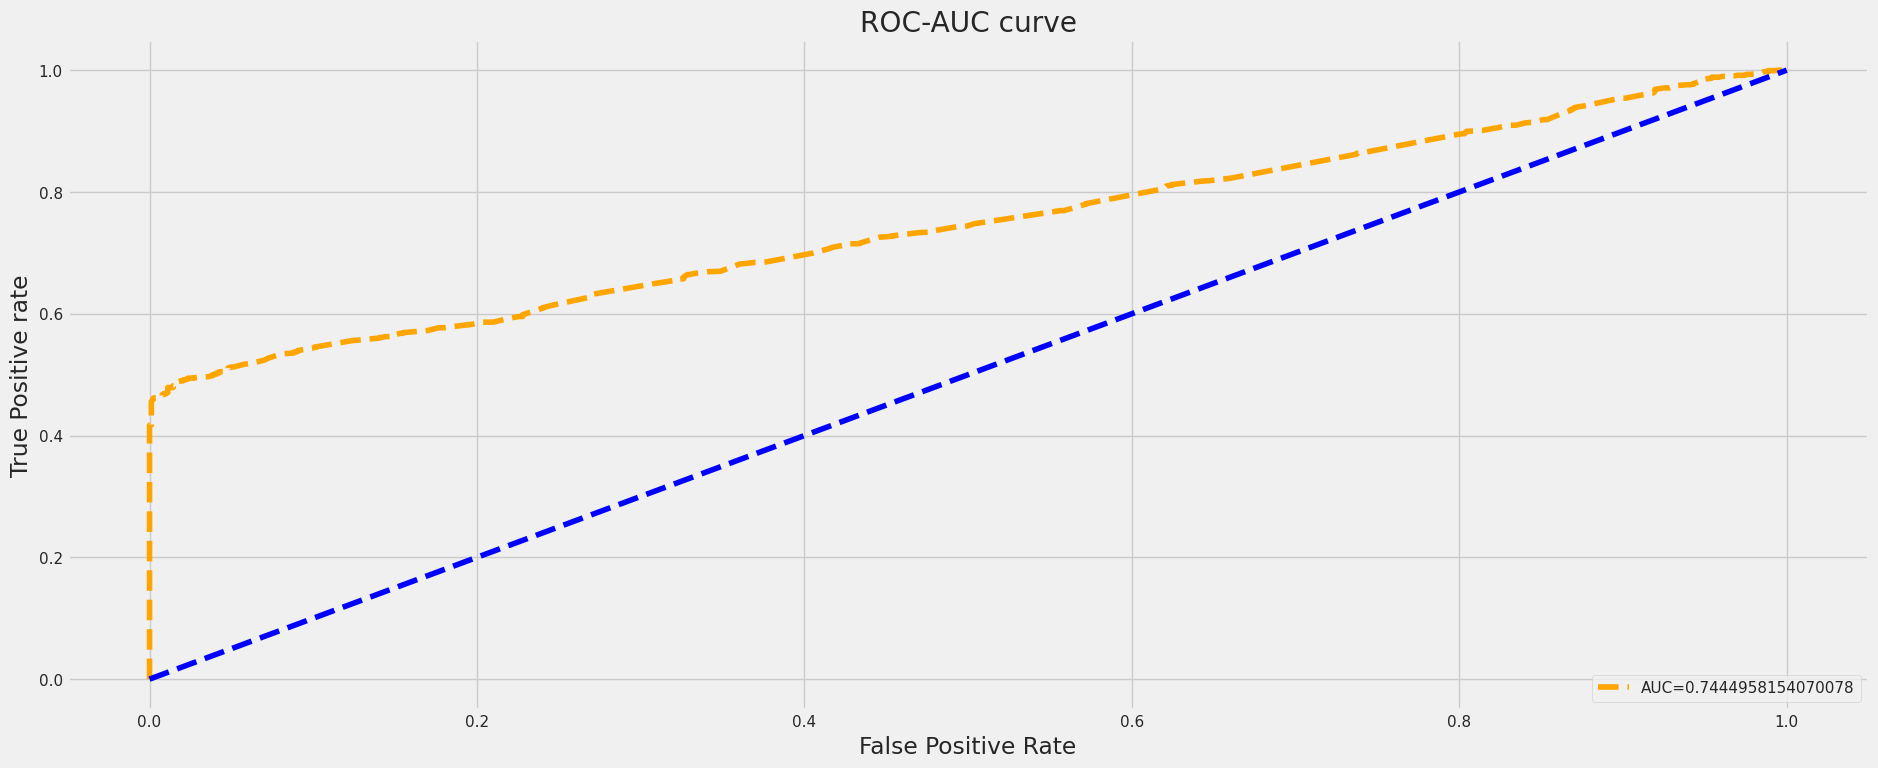

In [75]:
rfc = RandomForestClassifier(max_depth=5, max_features='auto', min_samples_split=10,
                       n_estimators=6, random_state=42).fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_pred_proba = rfc.predict_proba(X_test)
# roc curve for models
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba[:,1], pos_label=1)

auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--',color='orange', label="AUC="+str(auc))
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC-AUC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc=4)
plt.savefig('ROC',dpi=300)
plt.show();

Kurva ROC-AUC ditampilkan untuk memperlihatkan derajat keterpisahan antar kelas pada target.

In [76]:
# List of hyperparameter
hyperparameters = dict(n_estimators = [75, 100],
                       learning_rate = [0.5, 1],
                       algorithm = ['SAMME.R']
                      )

# Init model
ab = AdaBoostClassifier(random_state=42)
ab_tuned = GridSearchCV(ab, hyperparameters, cv=5, scoring='roc_auc')
ab_tuned.fit(X_train,y_train)

# Predict & Evaluation
eval_classification(ab_tuned)

Accuracy (Test Set): 0.68
Precision (Test Set): 0.83
Recall (Test Set): 0.58
roc_auc (test-proba): 0.74
roc_auc (train-proba): 0.75
accuracy (crossval train): 0.6777474969003862
accuracy (crossval test): 0.6673503152617706
precision (crossval train): 0.816996197096931
precision (crossval test): 0.805108840502147
recall (crossval train): 0.5953317846159306
recall (crossval test): 0.5863454323783615
roc_auc (crossval train): 0.7517240320202541
roc_auc (crossval test): 0.7381465949909437


In [77]:
ab_tuned.best_estimator_

AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=42)

In [78]:
hyperparameters = {
                    'max_depth' : [1, 5, 10],
                    'gamma' : [0, 0.5, 1],
                    'lambda' : [0, 0.5, 1],
                    'alpha' : [0, 0.5, 1]
                    }

# Init
xg = XGBClassifier(random_state=42)
xg_tuned = GridSearchCV(xg, hyperparameters, cv=5, scoring='roc_auc')
xg_tuned.fit(X_train,y_train)

# Predict & Evaluation
eval_classification(xg_tuned)

Accuracy (Test Set): 0.68
Precision (Test Set): 0.81
Recall (Test Set): 0.60
roc_auc (test-proba): 0.74
roc_auc (train-proba): 0.74
accuracy (crossval train): 0.728831534373426
accuracy (crossval test): 0.6614378650059434
precision (crossval train): 0.8657023904879774
precision (crossval test): 0.796080791314465
recall (crossval train): 0.6485834864587823
recall (crossval test): 0.589580084872998
roc_auc (crossval train): 0.8180881768466041
roc_auc (crossval test): 0.7283819877458947


In [79]:
xg_tuned.best_params_

{'alpha': 1, 'gamma': 0, 'lambda': 0.5, 'max_depth': 1}

In [80]:
learning_rate = [0.07]
depth=[1, 2]
l2_leaf_reg=[1, 2]
n_estimators = [10, 30, 50]

hyperparameters = dict(learning_rate=learning_rate, l2_leaf_reg=l2_leaf_reg,
                       depth=depth, n_estimators=n_estimators)

cb = CatBoostClassifier(random_state=42, verbose = False)
cs = GridSearchCV(cb, hyperparameters, scoring='roc_auc', cv=5)
cs.fit(X_train, y_train)
eval_classification(cs)

Accuracy (Test Set): 0.68
Precision (Test Set): 0.80
Recall (Test Set): 0.61
roc_auc (test-proba): 0.75
roc_auc (train-proba): 0.74
accuracy (crossval train): 0.6765541132844282
accuracy (crossval test): 0.6725775879890434
precision (crossval train): 0.8406839708792029
precision (crossval test): 0.8358579380570277
recall (crossval train): 0.5694204833304907
recall (crossval test): 0.5654173284179832
roc_auc (crossval train): 0.7473467891187929
roc_auc (crossval test): 0.7428749066220155


In [81]:
cs.best_params_

{'depth': 2, 'l2_leaf_reg': 1, 'learning_rate': 0.07, 'n_estimators': 30}

## Feature Importance

Untuk melihat feature importance dari masing-masing feature terhadap target, digunakan SHAP values sebagai alat bantu untuk interpretasi.

In [82]:
rf = RandomForestClassifier(max_depth=5, max_features='auto', min_samples_split=10,
                       n_estimators=6, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features='auto', min_samples_split=10,
                       n_estimators=6, random_state=42)

In [83]:
model = rf.fit(X_train, y_train)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

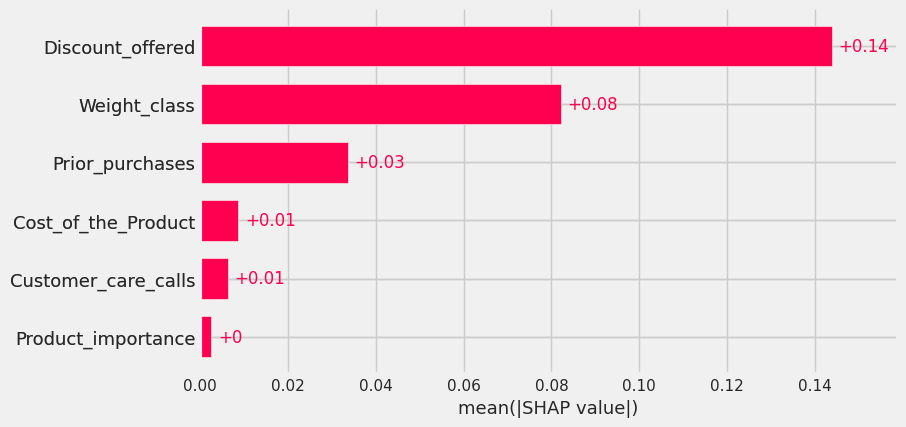

In [84]:
shap.plots.bar(shap_values[:,:,1])

Berdasarkan shap values, Discount_offered, Weight_class, dan Prior_purchases menjadi variabel yang memiliki pengaruh paling terbesar terhadap performa pengiriman barang, sedangkan Product_importance tidak memberikan pengaruh terhadap model. Tetapi belum diketahui pengaruh seperti apa yang diberikan masing-masing features terhadap model. Hal ini dapat dilihat di Shap Summary Plot (beeswarm).

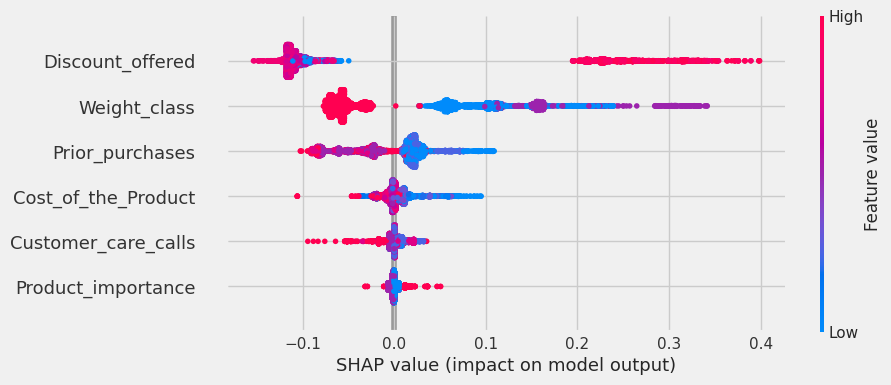

In [85]:
shap.plots.beeswarm(shap_values[:,:,1])

Berdasarkan Plot diatas diketahui bahwa Discount_offered dan Weight_class memberikan pengaruh positif dan negatif terhadap model, yang mana hal ini sesuai dengan informasi yang didapatkan saat EDA, bahwa pada taraf discount tertentu, barang akan terlambat pengirimannya, begitu juga dengan Weight_class, dimana pada kelompok berat tertentu, semuanya mengalami keterlambatan, dan pada kelompok berat yang lain, tidak mengalami keterlambatan.

# Business Recommendation

- Berdasarkan proses EDA dan analisis Feature Importance, diketahui bahwa barang dengan diskon di atas 10% pasti mengalami keterlambatan. Rekomendasi yang dapat diberikan yaitu penyesuaian pemberian diskon kepada barang dengan diskon >10%. Penyesuaian Discount Rate pada barang yang terlambat berpotensi menyebabkan trade-off antara Customer Loss dan jumlah transaksi potensial yang akan terjadi. Hasil revenue dari penyesuaian discount rate akan digunakan sebagai resources tambahan bagi Shoppedia untuk meningkatkan Delivery on Time rate.
- Berdasarkan proses EDA dan analisis Feature Importance, diketahui bahwa barang dengan berat 0 - 2000 gram dan 4000 - 6000 gram tidak semuanya mengalami keterlambatan. Sedangkan barang dengan berat 2000 - 4000 dan >6000 gram semuanya mengalami keterlambatan. Sehingga 2 kategori Weight_class tersebut (1 dan 3) perlu diberikan perhatian khusus untuk mencegah pengiriman barang terlambat.
Untuk 2 kategori berat tersebut dapat dilakukan:\
1. Menggunakan checkweigher untuk kategorisasi berat barang.
2. Pembuatan area warehouse khusus dan optimasi proses inbound dan outbound pada area warehouse khusus.
3. Improvisasi pada Warehouse Management System.
4. Membuat fitur tracking delivery khusus 2 kategori berat tersebut.
- Melakukan simulasi bisnis menggunakan prediksi model machine learning untuk mendapatkan prediksi barang yang terlambat, kemudian mengalokasikan resources yang tersedia untuk difokuskan kepada pengiriman barang yang diprediksi terlambat. Hal ini dapat meningkatkan Delivery on Time rate, dikarenakan penggunaan penggunaan resources yang tepat sasaran dan berfokus pada barang yang diprediksi terlambat berdasarkan hasil prediksi model machine learning.